from subprocess import check_output

cmd = 'git clone https://github.com/CSSEGISandData/COVID-19.git C:/Users/vibi/Desktop/test'
check_output(cmd, shell=True).decode()

In [297]:
#Load the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [298]:
#Load the data
df = pd.read_csv('sorted_data.csv')
df.head()

,FIPS,Province_State,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio,Year
0,12-31-2020,Tamil Nadu,01-01-2021 05:23,11.006091,78.400624,817077,12109,796353,8615.0,"Tamil Nadu, India",1049.670736,1.481990,2020
1,12-30-2020,Tamil Nadu,31-12-2020 05:22,11.006091,78.400624,817077,12109,796353,8615.0,"Tamil Nadu, India",1049.670736,1.481990,2020
2,12-29-2020,Tamil Nadu,30-12-2020 05:22,11.006091,78.400624,816132,12092,795293,8747.0,"Tamil Nadu, India",1048.456727,1.481623,2020
3,12-28-2020,Tamil Nadu,29-12-2020 05:22,11.006091,78.400624,815175,12080,794228,8867.0,"Tamil Nadu, India",1047.227302,1.481890,2020
4,12-27-2020,Tamil Nadu,28-12-2020 05:22,11.006091,78.400624,814170,12069,793154,8947.0,"Tamil Nadu, India",1045.936213,1.482369,2020


In [299]:
df = df.drop(['Deaths','Confirmed','Recovered','Province_State','Last_Update','Lat','Long_','Combined_Key','Incident_Rate','Case_Fatality_Ratio','Year'],axis=1)
#View the data ['Deaths','Confirmed']
df.head()

,FIPS,Active
0,12-31-2020,8615.0
1,12-30-2020,8615.0
2,12-29-2020,8747.0
3,12-28-2020,8867.0
4,12-27-2020,8947.0


In [300]:
df['abs_diff'] = df['Active'].diff().abs()

In [301]:
df.head()

,FIPS,Active,abs_diff
0,12-31-2020,8615.0,NaN
1,12-30-2020,8615.0,0.0
2,12-29-2020,8747.0,132.0
3,12-28-2020,8867.0,120.0
4,12-27-2020,8947.0,80.0


In [302]:
df = df.dropna().reset_index(drop=True)

In [303]:
df['FIPS'] = pd.to_datetime(df['FIPS'])
df.sort_values(by='FIPS')
# df.drop(pd.date_range('2020-06-10', '2020-12-31'),axis=1)

# date_filter = (df['FIPS'] < '2020-06-10') | (df['FIPS'] > '2020-12-31')
# filtered_df = df[date_filter]
# df =filtered_df
df

,FIPS,Active,abs_diff
0,2020-12-30,8615.000000,0.000000
1,2020-12-29,8747.000000,132.000000
2,2020-12-28,8867.000000,120.000000
3,2020-12-27,8947.000000,80.000000
4,2020-12-26,9039.000000,92.000000
...,...,...,...
997,2023-01-05,4617.713892,0.008993
998,2023-01-04,4617.702330,0.011562
999,2023-01-03,4617.686914,0.015416
1000,2023-01-02,4617.674067,0.012847


In [304]:
df.rename(columns = {'FIPS':'ds','Active':'y'}, inplace = True)

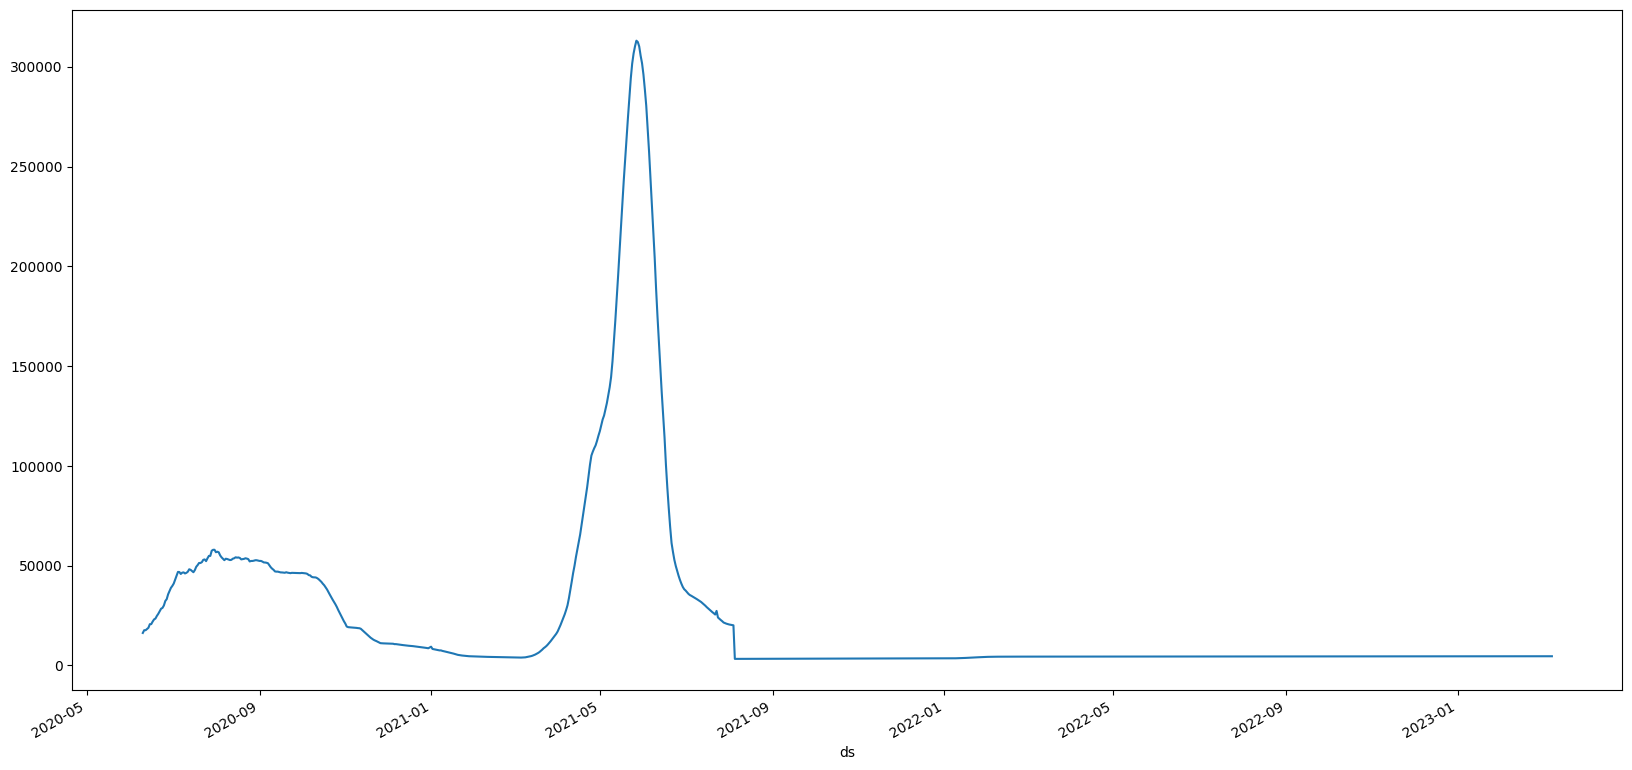

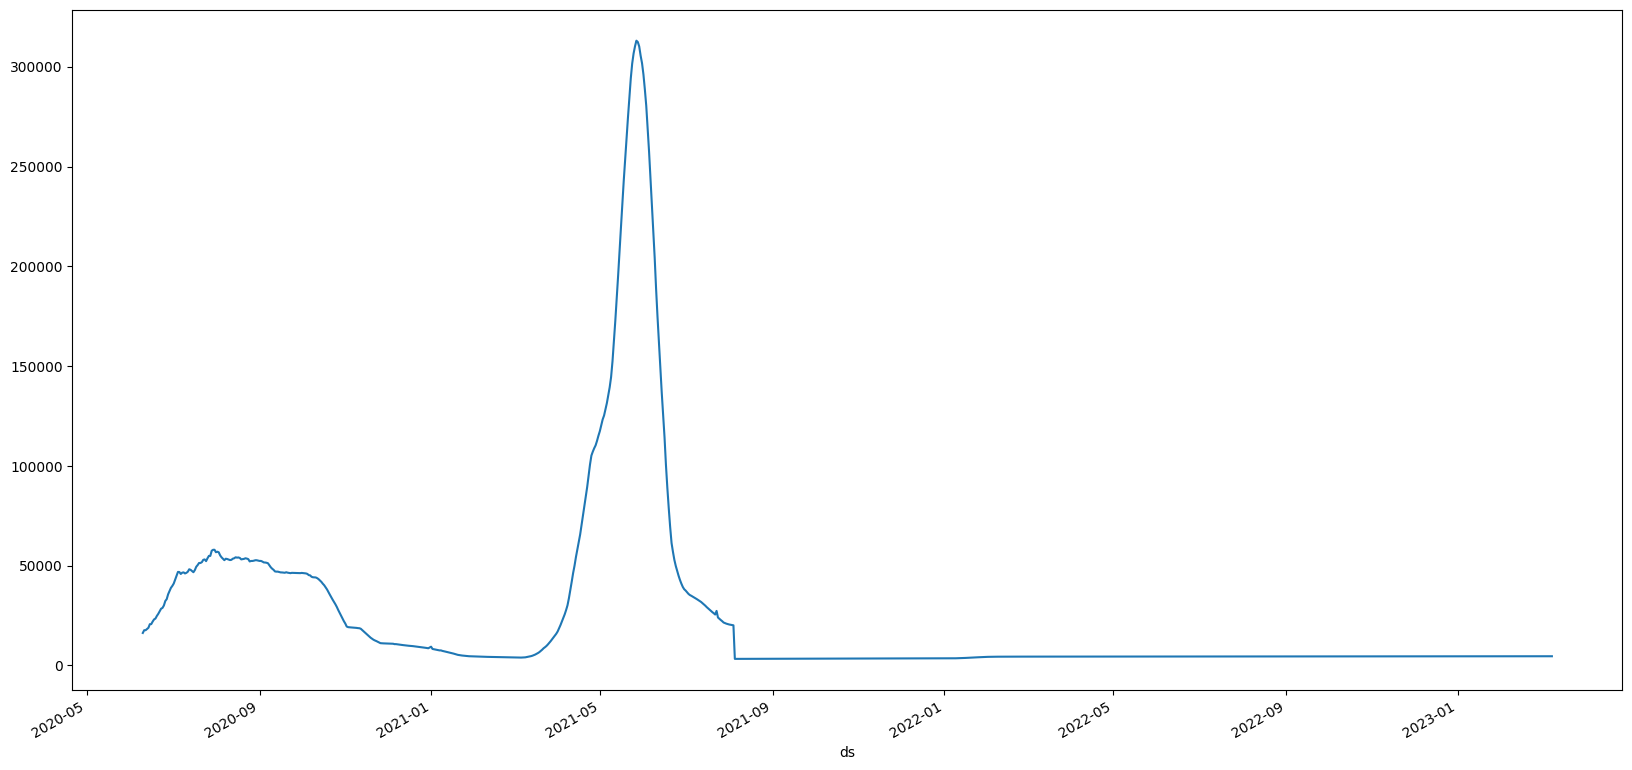

In [305]:
df.set_index('ds').y.plot().get_figure()

In [306]:
m = Prophet(changepoint_prior_scale=0.7, seasonality_prior_scale=30, holidays_prior_scale=20, n_changepoints=50, seasonality_mode='multiplicative')
m = m.fit(df)
future = m.make_future_dataframe(periods=100)
forecast = m.predict(future)

23:44:43 - cmdstanpy - INFO - Chain [1] start processing
23:44:45 - cmdstanpy - INFO - Chain [1] done processing


Text(0.5, 1.0, 'Active Case Forecast')

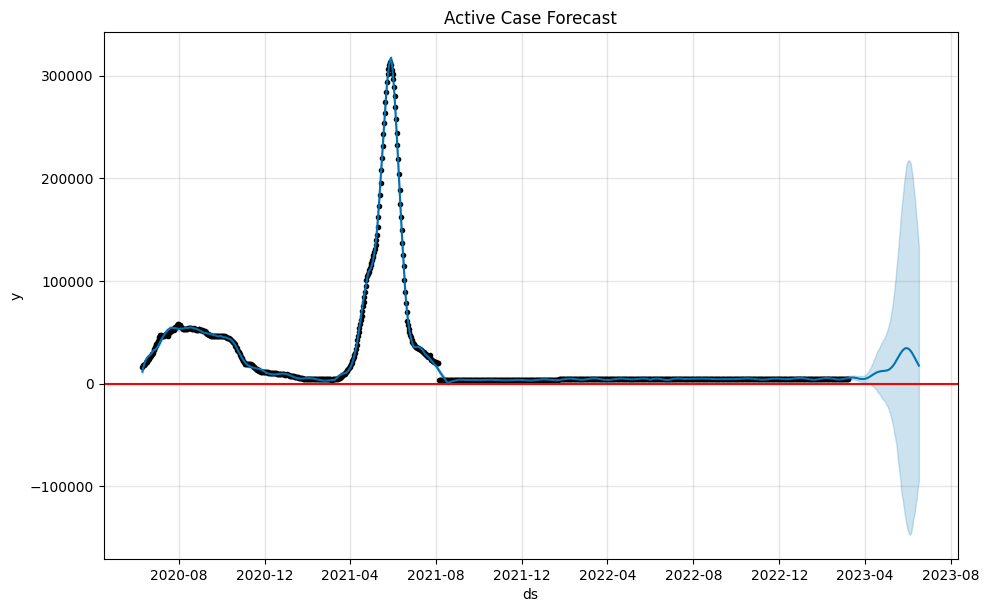

In [307]:
m.plot(forecast)
plt.axhline(y=0, color='red')
plt.title('Active Case Forecast')

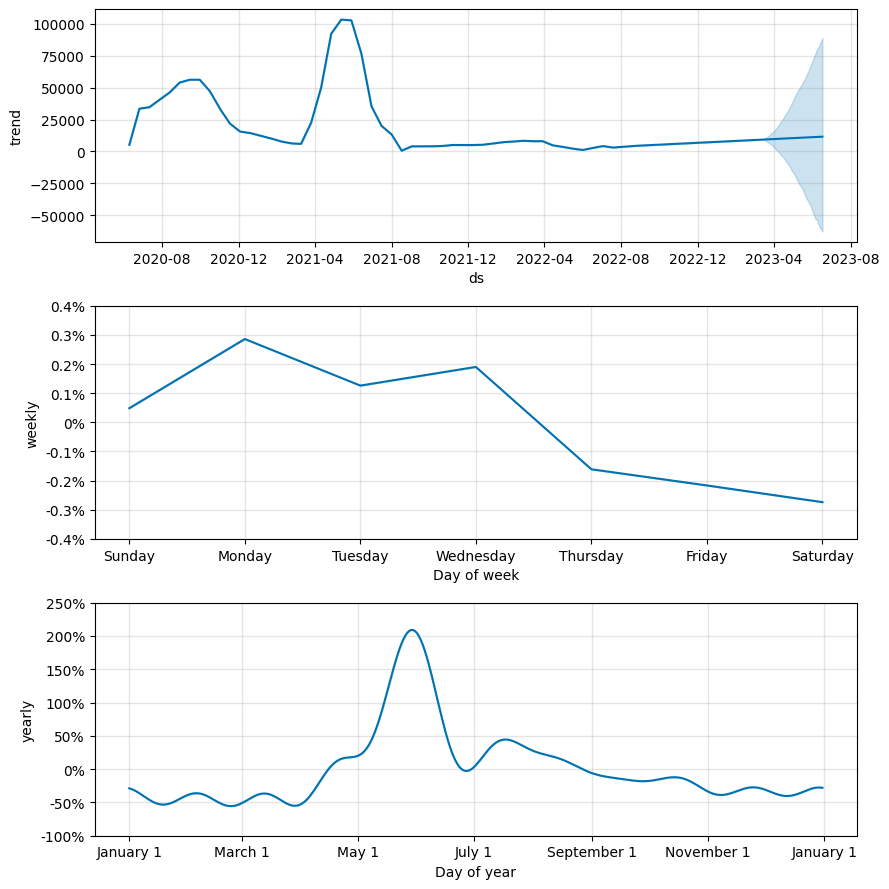

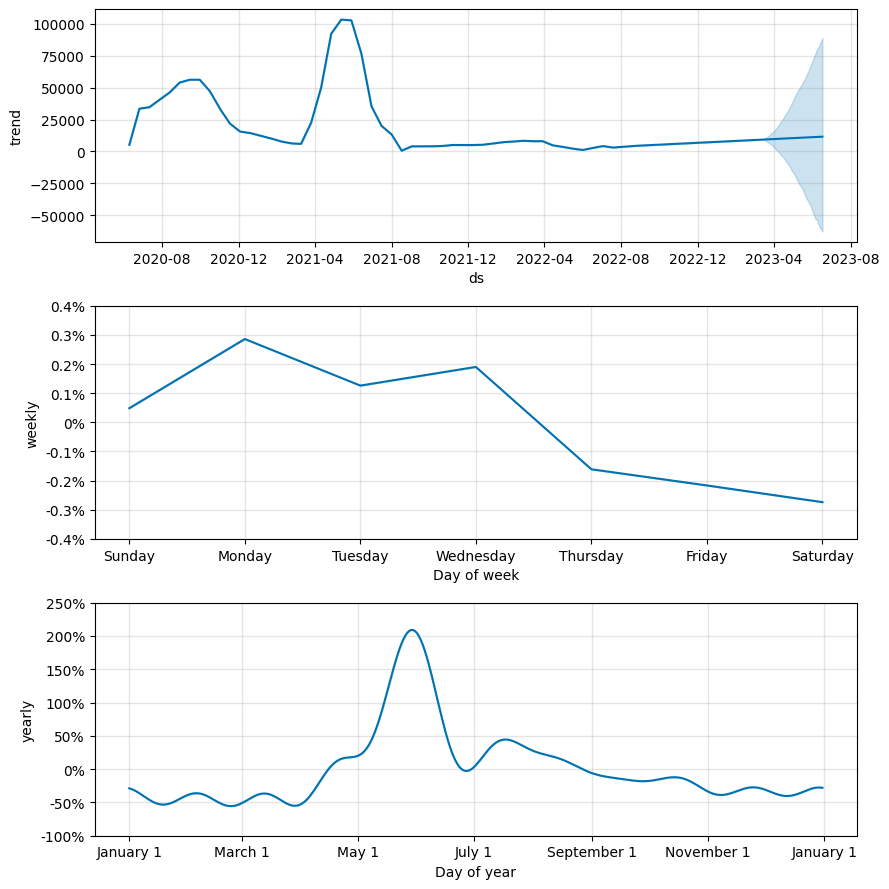

In [308]:
m.plot_components(forecast)

In [309]:
from prophet.diagnostics import cross_validation

df_cv = cross_validation(m, initial='600 days', period='380 days', horizon = '100 days')

  0%|          | 0/1 [00:00<?, ?it/s]

23:44:49 - cmdstanpy - INFO - Chain [1] start processing
23:44:53 - cmdstanpy - INFO - Chain [1] done processing


In [310]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2022-11-30,4778.870285,3060.903275,6561.040807,4617.273252,2022-11-29
1,2022-12-01,4766.516998,2936.450768,6586.241148,4617.292522,2022-11-29
2,2022-12-02,4769.052685,3013.114933,6527.809149,4617.310507,2022-11-29
3,2022-12-03,4774.416533,2976.658864,6592.557391,4617.327208,2022-11-29
4,2022-12-04,4794.113161,2945.146804,6510.233071,4617.342624,2022-11-29


In [311]:
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
95,2023-03-05,4079.213247,-20568.837162,28951.751653,4618.375495,2022-11-29
96,2023-03-06,4131.574753,-21533.262331,30224.364800,4618.410181,2022-11-29
97,2023-03-07,4146.806794,-21436.343481,30577.360482,4618.446151,2022-11-29
98,2023-03-08,4203.138129,-21871.699526,30836.227557,4618.487261,2022-11-29
99,2023-03-09,4240.613655,-22158.716865,31530.466322,4618.530939,2022-11-29


In [312]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,10 days,80135.000454,283.081261,258.719948,0.056032,0.046669,0.054222,1.0
1,11 days,110898.721186,333.014596,300.331415,0.065044,0.059327,0.062558,1.0
2,12 days,157577.192402,396.959938,355.341267,0.076957,0.070325,0.073456,1.0
3,13 days,234555.093621,484.308882,429.206630,0.092954,0.082308,0.087811,1.0
4,14 days,342244.358849,585.016546,518.453389,0.112282,0.096065,0.104876,1.0


In [313]:
df_p.tail()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
86,96 days,534434.525145,731.050289,581.779689,0.125975,0.106685,0.118199,1.0
87,97 days,313400.365619,559.821727,474.023136,0.102641,0.105102,0.100358,1.0
88,98 days,205878.604358,453.738476,407.272135,0.088186,0.103457,0.089161,1.0
89,99 days,164690.731101,405.821058,372.361405,0.080626,0.096026,0.083290,1.0
90,100 days,153829.920279,392.211576,360.010379,0.077951,0.085879,0.081523,1.0


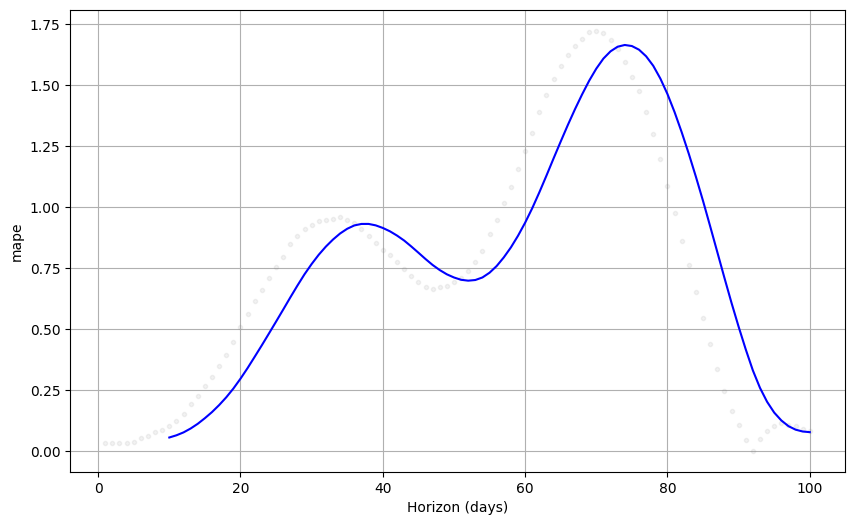

In [314]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

# ----------- SVM  ------------ #

In [315]:
import numpy as nm  
import matplotlib.pyplot as mtp  
import pandas as pd  
import matplotlib.pyplot as plt


In [316]:
#importing datasets  
df_for_svm= pd.read_csv('sorted_data_for_test.csv')
df_for_svm.head()

,FIPS,Province_State,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio,Year
0,12-31-2020,Tamil Nadu,01-01-2021 05:23,11.006091,78.400624,817077,12109,796353,8615.0,"Tamil Nadu, India",1049.670736,1.481990,2020
1,12-30-2020,Tamil Nadu,31-12-2020 05:22,11.006091,78.400624,817077,12109,796353,8615.0,"Tamil Nadu, India",1049.670736,1.481990,2020
2,12-29-2020,Tamil Nadu,30-12-2020 05:22,11.006091,78.400624,816132,12092,795293,8747.0,"Tamil Nadu, India",1048.456727,1.481623,2020
3,12-28-2020,Tamil Nadu,29-12-2020 05:22,11.006091,78.400624,815175,12080,794228,8867.0,"Tamil Nadu, India",1047.227302,1.481890,2020
4,12-27-2020,Tamil Nadu,28-12-2020 05:22,11.006091,78.400624,814170,12069,793154,8947.0,"Tamil Nadu, India",1045.936213,1.482369,2020


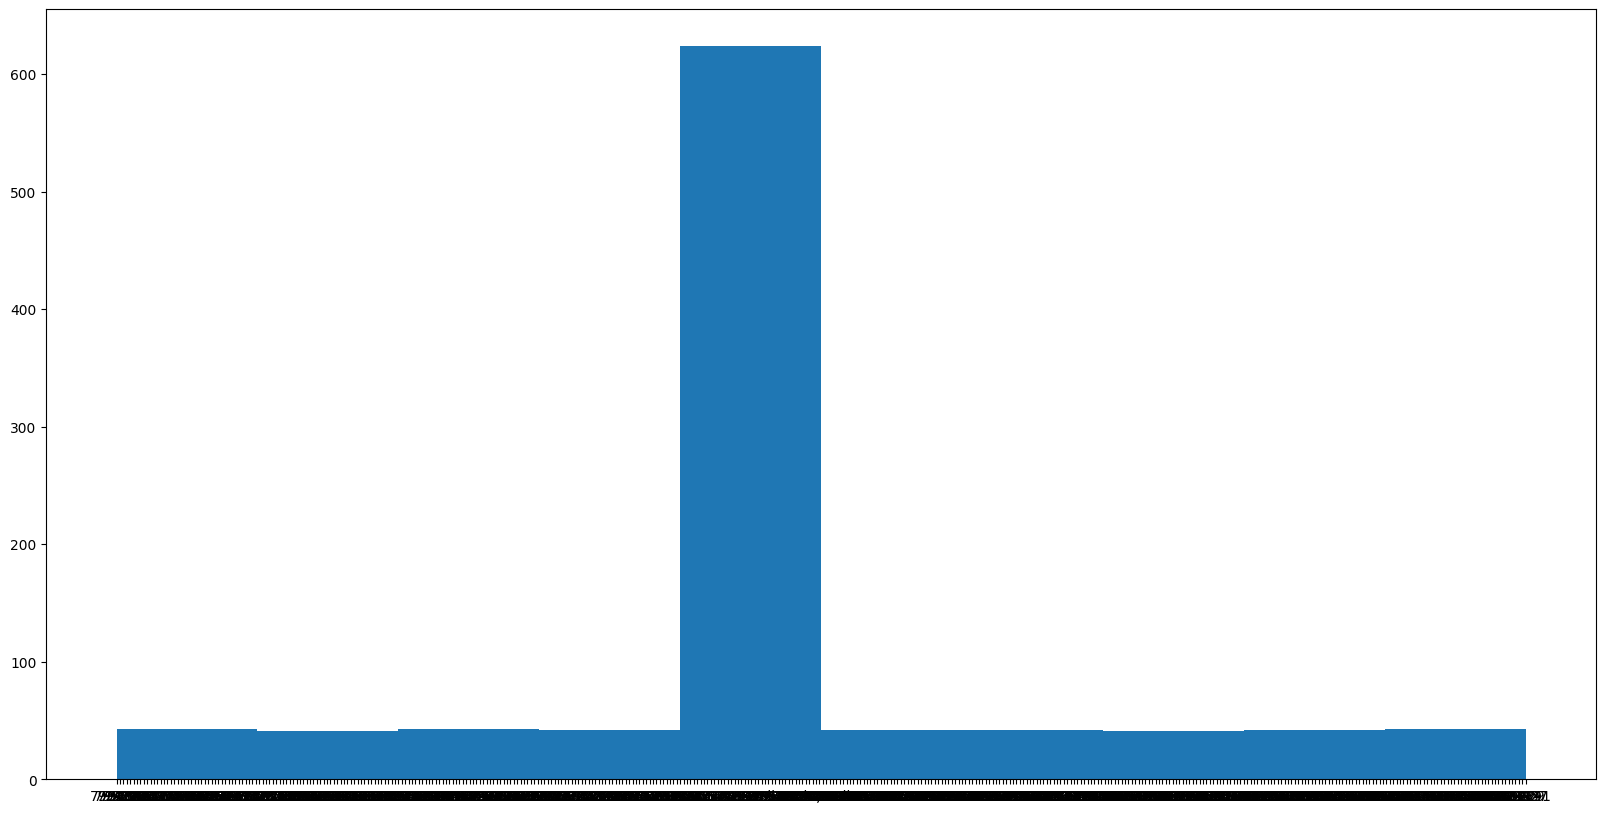

In [317]:
plt.hist(df_for_svm['Recovered'])
plt.show()

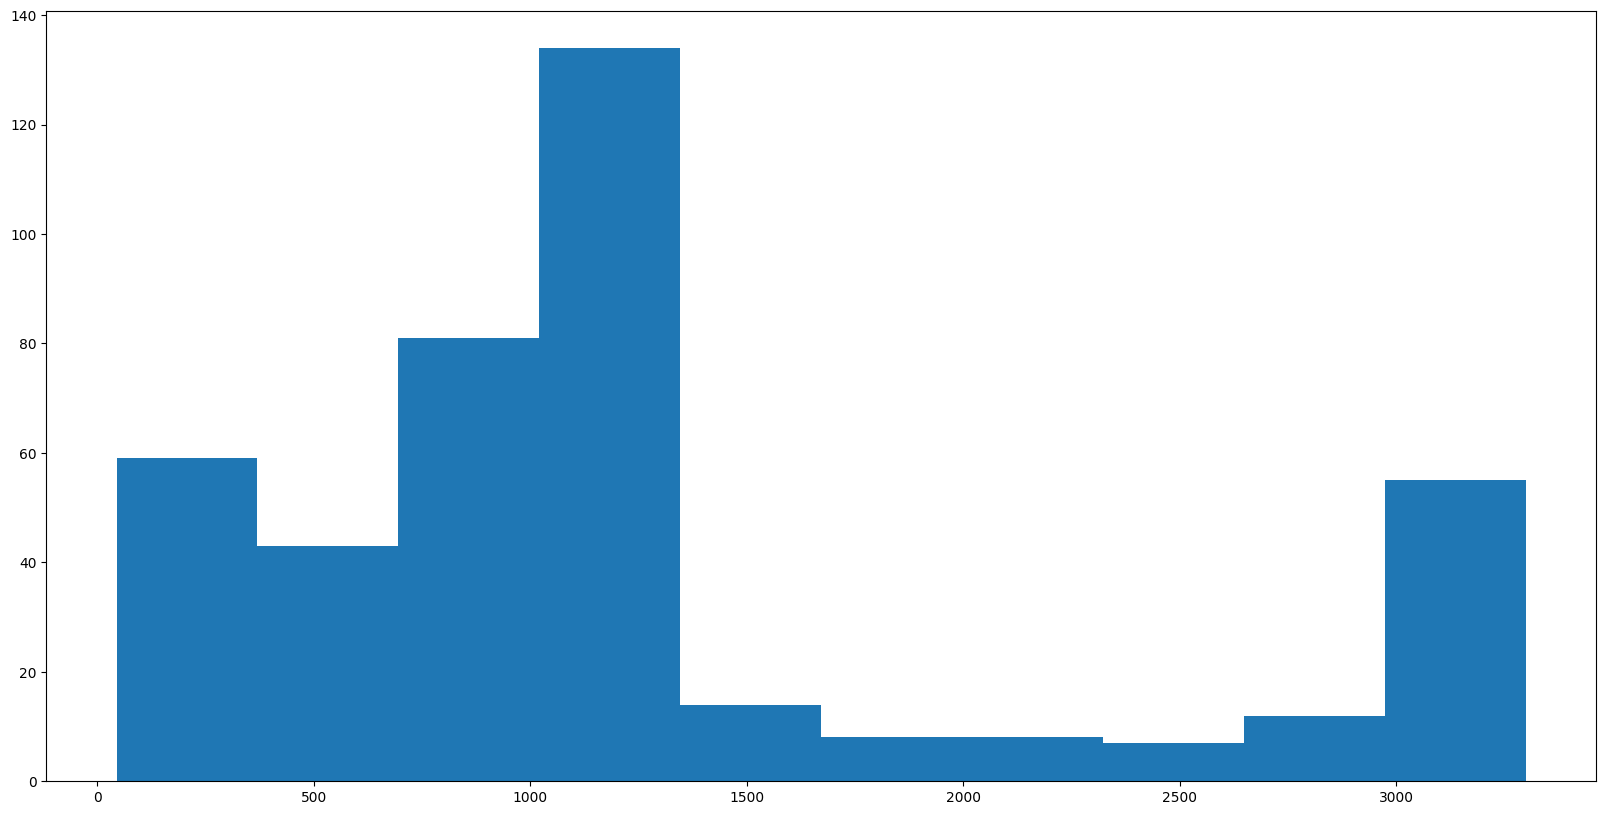

In [318]:
plt.hist(df_for_svm['Incident_Rate'])
plt.show()

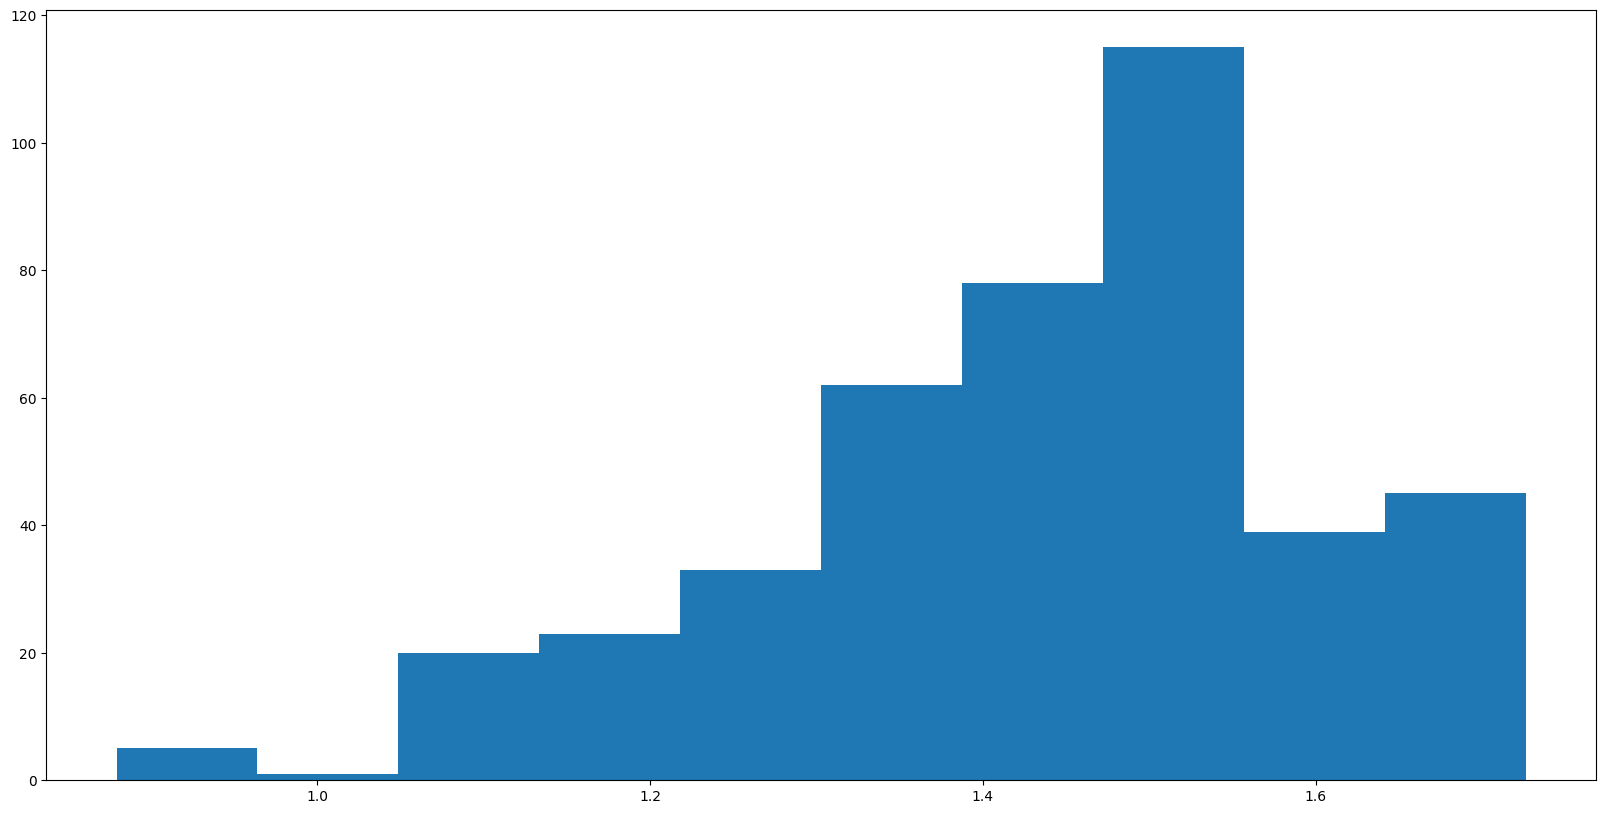

In [319]:
plt.hist(df_for_svm['Case_Fatality_Ratio'])
plt.show()

In [320]:
df_for_svm['Recovered'] = df_for_svm['Recovered'].apply(pd.to_numeric, errors='coerce')

In [321]:
updated_df_svm = df_for_svm

In [322]:
updated_df_svm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   FIPS                 1003 non-null   object 
 1   Province_State       1003 non-null   object 
 2   Last_Update          1003 non-null   object 
 3   Lat                  1003 non-null   float64
 4   Long_                1003 non-null   float64
 5   Confirmed            1003 non-null   int64  
 6   Deaths               1003 non-null   int64  
 7   Recovered            421 non-null    float64
 8   Active               1003 non-null   float64
 9   Combined_Key         1003 non-null   object 
 10  Incident_Rate        421 non-null    float64
 11  Case_Fatality_Ratio  421 non-null    float64
 12  Year                 1003 non-null   int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 102.0+ KB


In [323]:
updated_df_svm['Recovered']=updated_df_svm['Recovered'].fillna(updated_df_svm['Recovered'].median())
updated_df_svm['Incident_Rate']=updated_df_svm['Incident_Rate'].fillna(updated_df_svm['Incident_Rate'].median())
updated_df_svm['Case_Fatality_Ratio']=updated_df_svm['Case_Fatality_Ratio'].fillna(updated_df_svm['Case_Fatality_Ratio'].median())

In [324]:
updated_df_svm.isnull().sum()

FIPS                   0
Province_State         0
Last_Update            0
Lat                    0
Long_                  0
Confirmed              0
Deaths                 0
Recovered              0
Active                 0
Combined_Key           0
Incident_Rate          0
Case_Fatality_Ratio    0
Year                   0
dtype: int64

In [325]:
updated_df_svm['abs_diffActive'] = updated_df_svm['Active'].diff().abs()
updated_df_svm['abs_diffConfirmed'] = updated_df_svm['Confirmed'].diff().abs()
updated_df_svm['abs_diffDeaths'] = updated_df_svm['Deaths'].diff().abs()
updated_df_svm['abs_diffRecovered'] = updated_df_svm['Recovered'].diff().abs()

In [326]:
updated_df_svm.head()

,FIPS,Province_State,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio,Year,abs_diffActive,abs_diffConfirmed,abs_diffDeaths,abs_diffRecovered
0,12-31-2020,Tamil Nadu,01-01-2021 05:23,11.006091,78.400624,817077,12109,796353.0,8615.0,"Tamil Nadu, India",1049.670736,1.481990,2020,NaN,NaN,NaN,NaN
1,12-30-2020,Tamil Nadu,31-12-2020 05:22,11.006091,78.400624,817077,12109,796353.0,8615.0,"Tamil Nadu, India",1049.670736,1.481990,2020,0.0,0.0,0.0,0.0
2,12-29-2020,Tamil Nadu,30-12-2020 05:22,11.006091,78.400624,816132,12092,795293.0,8747.0,"Tamil Nadu, India",1048.456727,1.481623,2020,132.0,945.0,17.0,1060.0
3,12-28-2020,Tamil Nadu,29-12-2020 05:22,11.006091,78.400624,815175,12080,794228.0,8867.0,"Tamil Nadu, India",1047.227302,1.481890,2020,120.0,957.0,12.0,1065.0
4,12-27-2020,Tamil Nadu,28-12-2020 05:22,11.006091,78.400624,814170,12069,793154.0,8947.0,"Tamil Nadu, India",1045.936213,1.482369,2020,80.0,1005.0,11.0,1074.0


In [327]:
updated_df_svm = updated_df_svm.dropna().reset_index(drop=True)

In [328]:
updated_df_svm.head()

,FIPS,Province_State,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio,Year,abs_diffActive,abs_diffConfirmed,abs_diffDeaths,abs_diffRecovered
0,12-30-2020,Tamil Nadu,31-12-2020 05:22,11.006091,78.400624,817077,12109,796353.0,8615.0,"Tamil Nadu, India",1049.670736,1.481990,2020,0.0,0.0,0.0,0.0
1,12-29-2020,Tamil Nadu,30-12-2020 05:22,11.006091,78.400624,816132,12092,795293.0,8747.0,"Tamil Nadu, India",1048.456727,1.481623,2020,132.0,945.0,17.0,1060.0
2,12-28-2020,Tamil Nadu,29-12-2020 05:22,11.006091,78.400624,815175,12080,794228.0,8867.0,"Tamil Nadu, India",1047.227302,1.481890,2020,120.0,957.0,12.0,1065.0
3,12-27-2020,Tamil Nadu,28-12-2020 05:22,11.006091,78.400624,814170,12069,793154.0,8947.0,"Tamil Nadu, India",1045.936213,1.482369,2020,80.0,1005.0,11.0,1074.0
4,12-26-2020,Tamil Nadu,27-12-2020 05:22,11.006091,78.400624,813161,12059,792063.0,9039.0,"Tamil Nadu, India",1044.639985,1.482978,2020,92.0,1009.0,10.0,1091.0


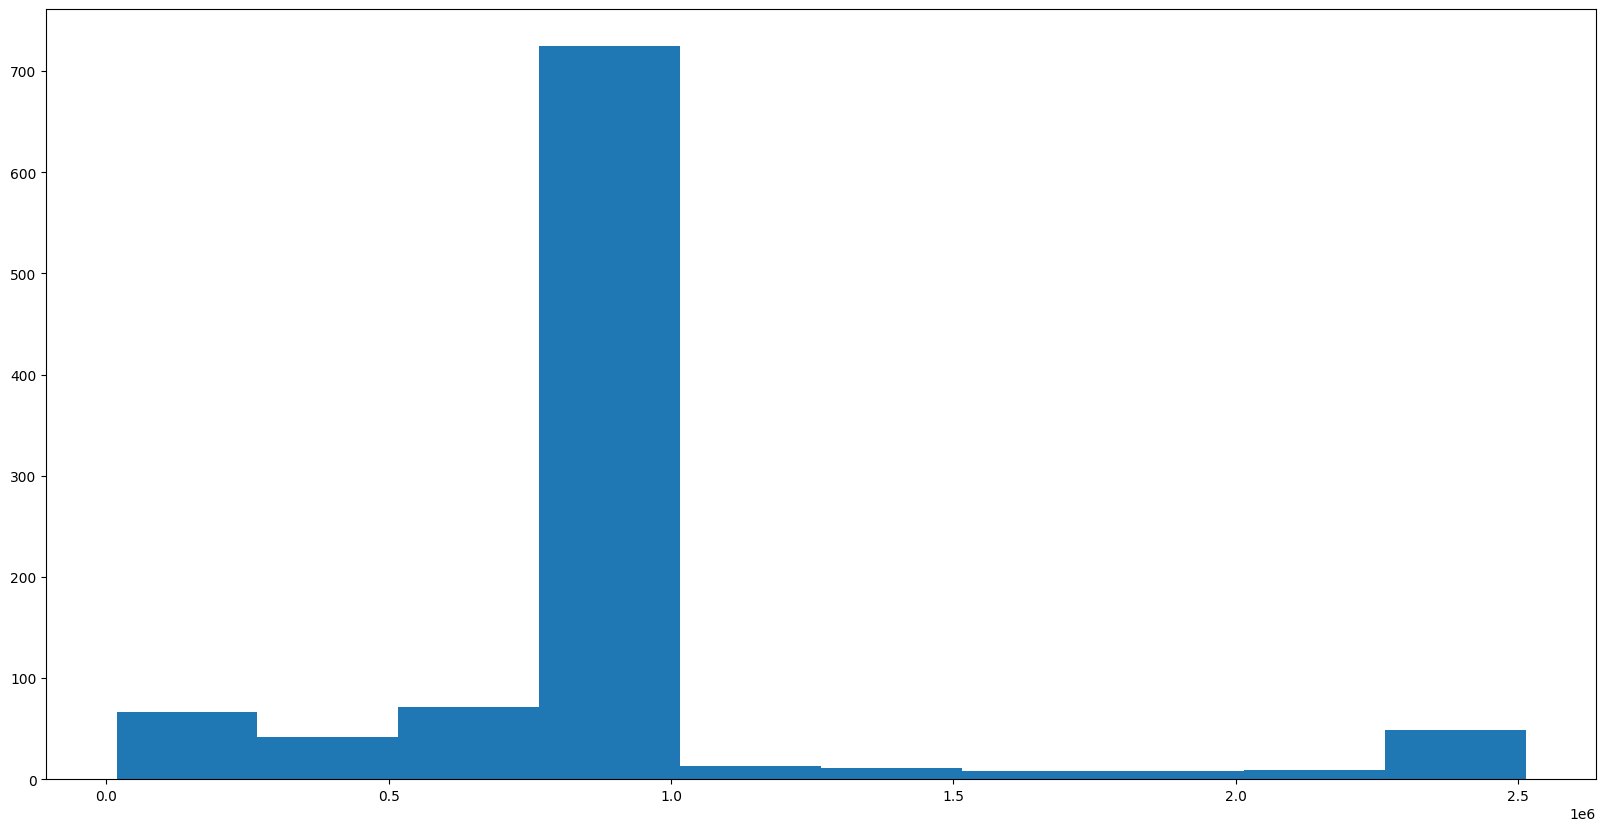

In [329]:
plt.hist(updated_df_svm['Recovered'])
plt.show() 

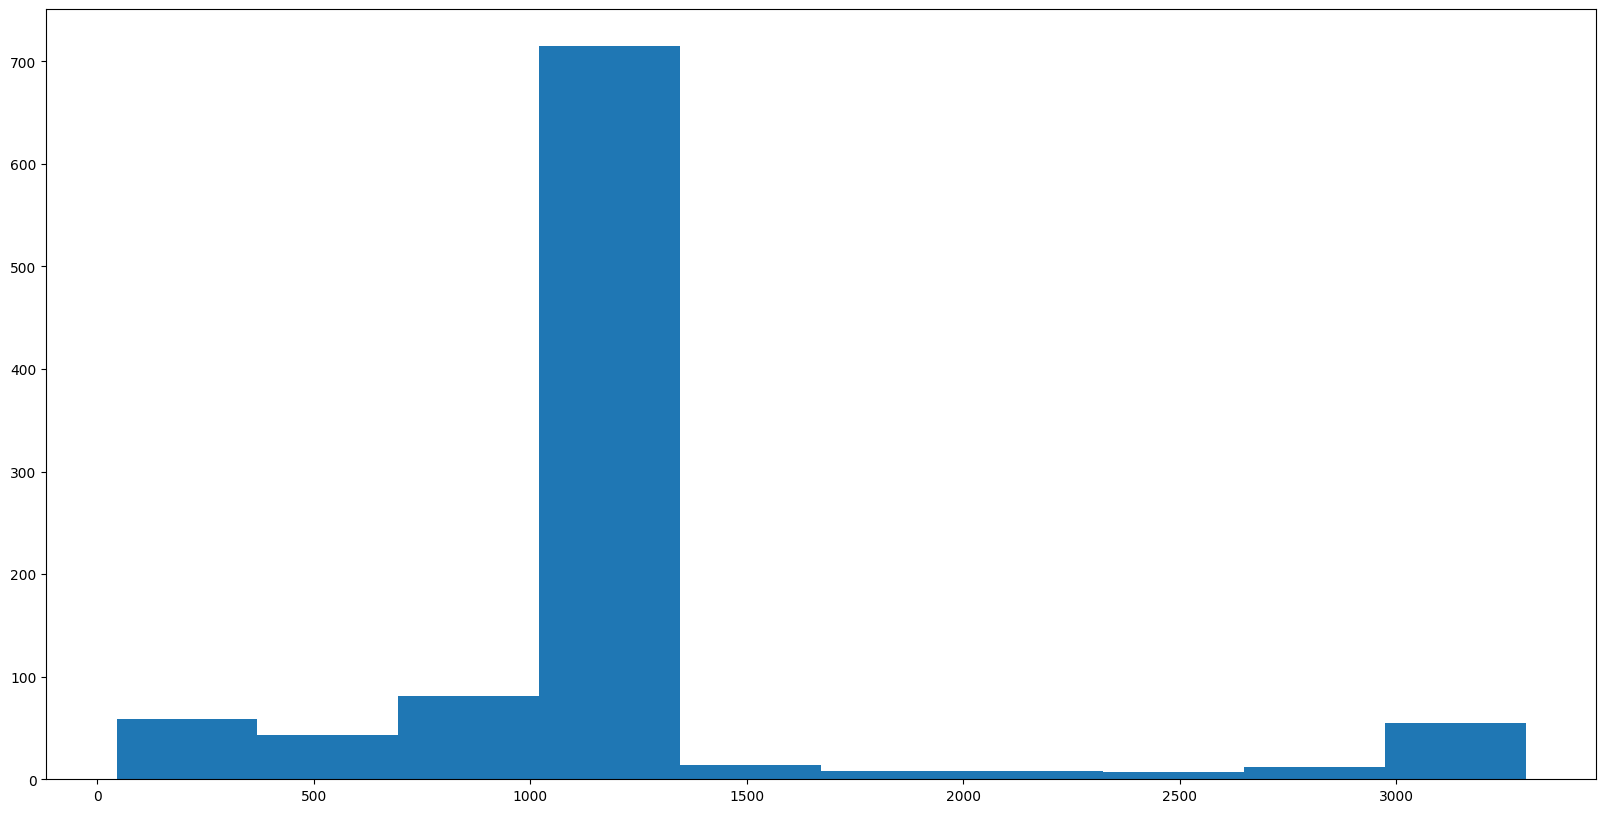

In [330]:
plt.hist(updated_df_svm['Incident_Rate'])
plt.show() 

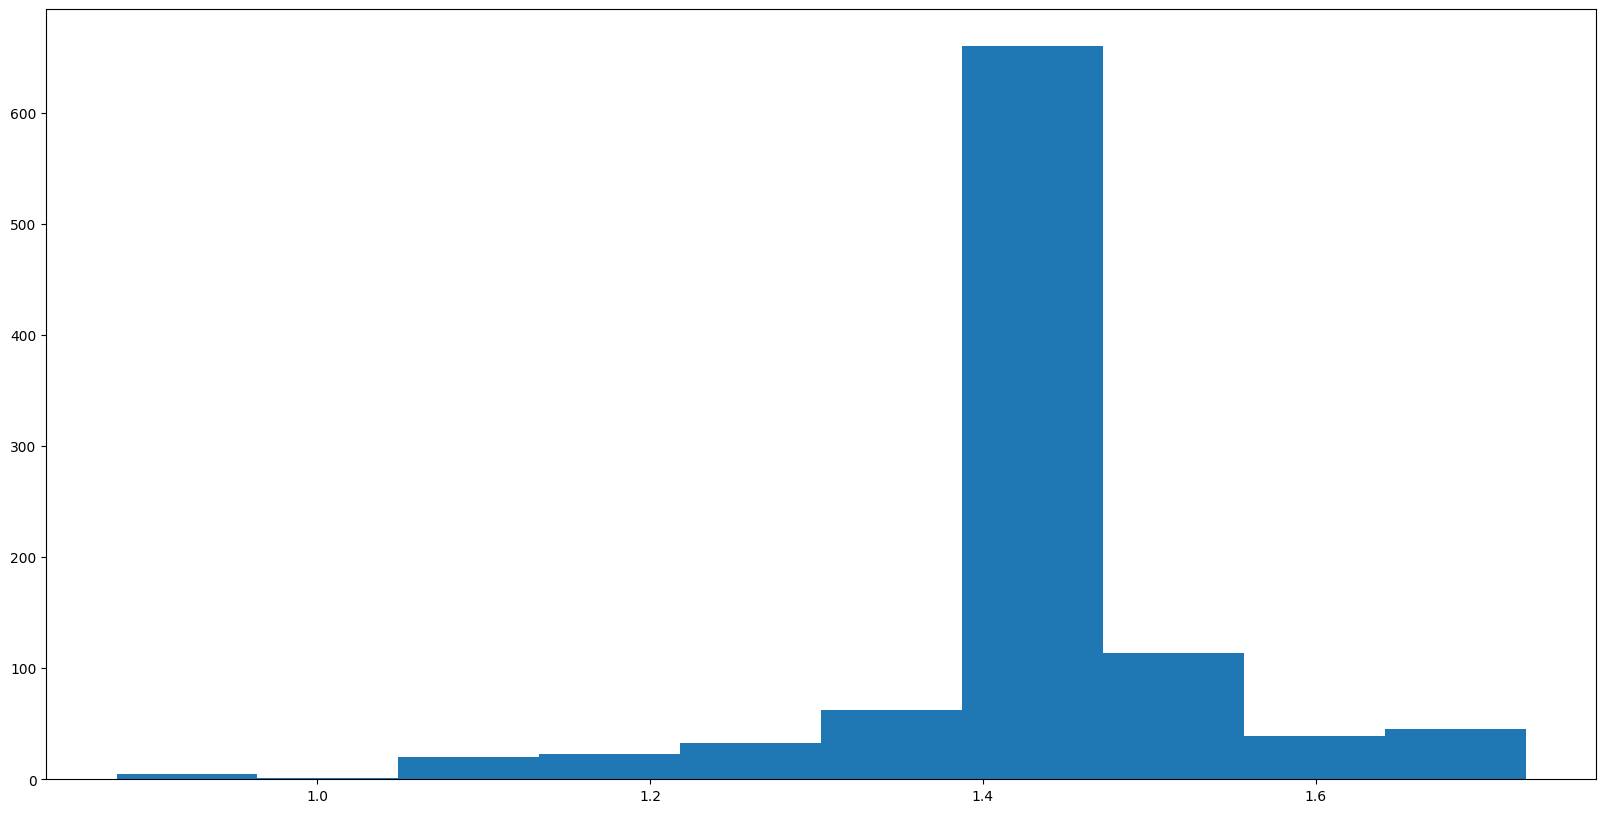

In [331]:
plt.hist(updated_df_svm['Case_Fatality_Ratio'])
plt.show() 

In [332]:
from sklearn import preprocessing
from sklearn import utils

#Extracting Independent and dependent Variable  
x= df_for_svm[['Confirmed','Deaths','Recovered','Incident_Rate','Case_Fatality_Ratio']]
y= df_for_svm['Active']

# x = updated_df[['abs_diffConfirmed', 'abs_diffDeaths', 'abs_diffRecovered','Incident_Rate','Case_Fatality_Ratio']]
# y = updated_df['abs_diffActive'] 

#y= y.apply(lambda x: 0 if x >= 1 else 1)
# y = df['Case_Fatality_Ratio']
# # # set the number of bins to 2
# # n_bins = 2

# # # use pandas cut function to convert continuous values to 0s and 1s
# # y = pd.cut(y, n_bins, labels=[0, 1])
# y= y.apply(lambda x: 0 if x >= 1 else 1)


# y.tail()

In [333]:
x.head()

,Confirmed,Deaths,Recovered,Incident_Rate,Case_Fatality_Ratio
0,817077,12109,796353.0,1049.670736,1.481990
1,817077,12109,796353.0,1049.670736,1.481990
2,816132,12092,795293.0,1048.456727,1.481623
3,815175,12080,794228.0,1047.227302,1.481890
4,814170,12069,793154.0,1045.936213,1.482369


In [334]:
y.head()

0    8615.0
1    8615.0
2    8747.0
3    8867.0
4    8947.0
Name: Active, dtype: float64

In [335]:
# Splitting the dataset into training and test set.  
from sklearn.model_selection import train_test_split  
x_train, x_test, y_train, y_test= train_test_split(x, y, test_size= 0.05, random_state=42)  


In [336]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)

In [337]:
# Create SVR model
svr = SVR(kernel='poly', C=100, epsilon=0.1) #changed c from 1 to 100 because accuracy increased

In [338]:
# Fit the model on the training data
svr.fit(X_train_scaled, y_train)

SVR(C=100, kernel='poly')

In [339]:
# Make predictions on the test data
y_train_pred = svr.predict(X_train_scaled)
y_test_pred = svr.predict(X_test_scaled)


In [340]:
# Calculating accuracy metrics for the training set
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
accuracy_train = (train_r2 + 1) / 2 * 100

In [341]:
print("Train Mean Squared Error:", train_mse)
print("Train R-squared:", train_r2)
print(accuracy_train)

Train Mean Squared Error: 1145157893.6829972
Train R-squared: 0.5368163853891834
76.84081926945917


In [342]:
# Calculating accuracy metrics for the testing set
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
accuracy_test = (test_r2 + 1) / 2 * 100

In [343]:
print("test Mean Squared Error:", test_mse)
print("test R-squared:", test_r2)
print(accuracy_test)

test Mean Squared Error: 175096034.60183173
test R-squared: 0.49487163313528926
74.74358165676446


In [344]:
print("SVR train accuracy kernel='poly': {:.2f}%".format(accuracy_train))
print("SVR test accuracy kernel='poly': {:.2f}%".format(accuracy_test))

SVR train accuracy kernel='poly': 76.84%
SVR test accuracy kernel='poly': 74.74%


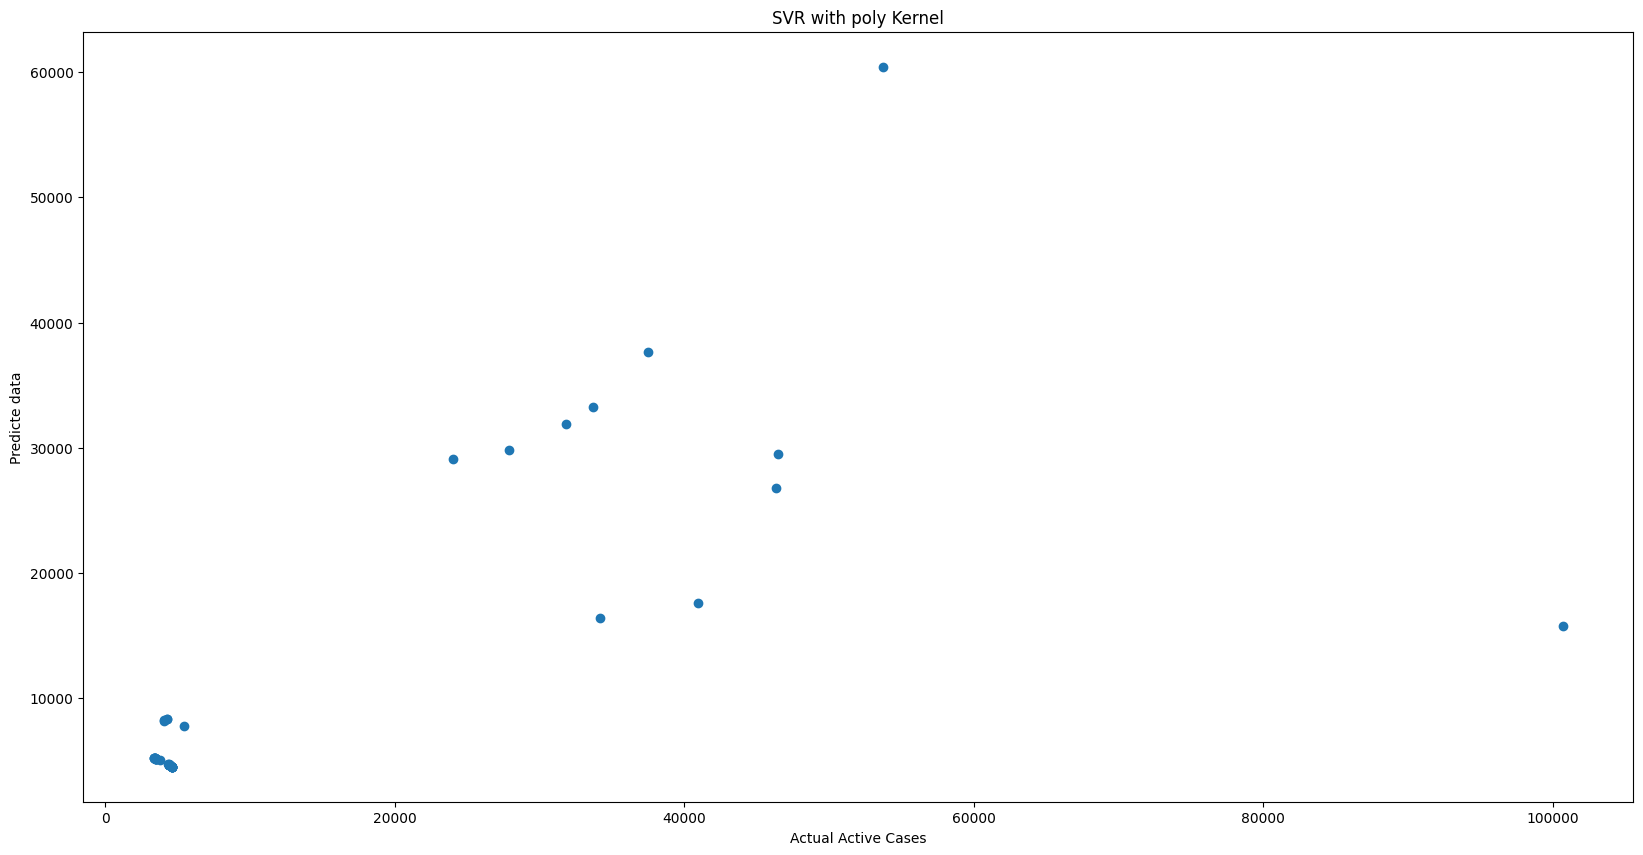

In [345]:
plt.scatter(y_test, y_test_pred)
plt.xlabel('Actual Active Cases')
plt.ylabel('Predicte data')
plt.title('SVR with poly Kernel')
plt.show()

# ---------SVR rbf kernel------ #

In [346]:
# Create and fit the SVR model with RBF kernel
model = SVR(kernel='rbf',epsilon=0.9, C=1.0)
model.fit(X_train_scaled, y_train)

SVR(epsilon=0.9)

In [347]:
# Predict the target variable for the test set
y_train_predRBF = model.predict(X_train_scaled)
y_test_predRBF = model.predict(X_test_scaled)

In [348]:
# Calculating accuracy metrics for the training set
train_mse_rbf = mean_squared_error(y_train, y_train_predRBF)
train_r2_rbf = r2_score(y_train, y_train_predRBF)
accuracy_train_rbf = (train_r2_rbf + 1) / 2 * 100

In [349]:
mse = mean_squared_error(y_test, y_test_predRBF)
r2 = r2_score(y_test, y_test_predRBF)

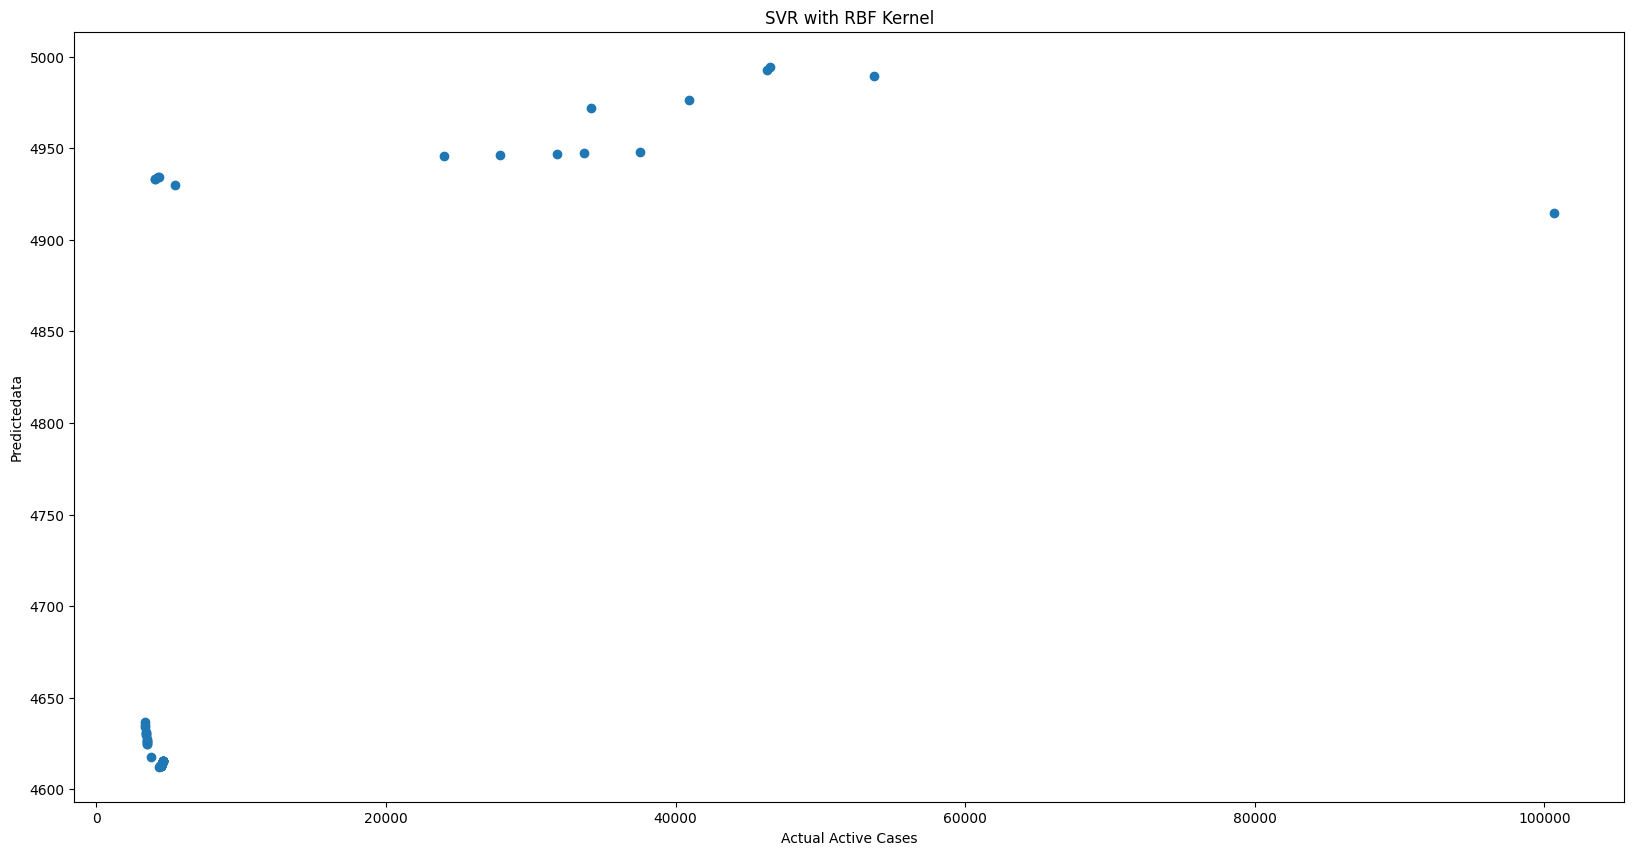

In [350]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_test_predRBF)
plt.xlabel('Actual Active Cases')
plt.ylabel('Predictedata')
plt.title('SVR with RBF Kernel')
plt.show()

In [351]:
score_test_rbf = r2_score(y_test, y_test_predRBF)
accuracy_test_rbf = (score_test_rbf + 1) / 2 * 100
print("SVR train accuracy: {:.2f}%".format(accuracy_train_rbf))
print("SVR test accuracy: {:.2f}%".format(accuracy_test_rbf))

SVR train accuracy: 42.32%
SVR test accuracy: 41.62%


In [352]:
import pandas as pd
import numpy as np

In [353]:
#to plot within notebook
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

In [354]:
#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [355]:
import warnings
warnings.filterwarnings('ignore')

In [356]:
pd.set_option('display.max_columns', 100) 
activeCase = pd.read_csv('sorted_data.csv' )
activeCase.head()

,FIPS,Province_State,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio,Year
0,12-31-2020,Tamil Nadu,01-01-2021 05:23,11.006091,78.400624,817077,12109,796353,8615.0,"Tamil Nadu, India",1049.670736,1.481990,2020
1,12-30-2020,Tamil Nadu,31-12-2020 05:22,11.006091,78.400624,817077,12109,796353,8615.0,"Tamil Nadu, India",1049.670736,1.481990,2020
2,12-29-2020,Tamil Nadu,30-12-2020 05:22,11.006091,78.400624,816132,12092,795293,8747.0,"Tamil Nadu, India",1048.456727,1.481623,2020
3,12-28-2020,Tamil Nadu,29-12-2020 05:22,11.006091,78.400624,815175,12080,794228,8867.0,"Tamil Nadu, India",1047.227302,1.481890,2020
4,12-27-2020,Tamil Nadu,28-12-2020 05:22,11.006091,78.400624,814170,12069,793154,8947.0,"Tamil Nadu, India",1045.936213,1.482369,2020


In [357]:
activeCase.tail()

,FIPS,Province_State,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio,Year
998,01-05-2023,Tamil Nadu,06-01-2023 04:21,11.006091,78.400624,3594487,38049,"Tamil Nadu, India",4617.713892,1.0585377,NaN,NaN,2023
999,01-04-2023,Tamil Nadu,05-01-2023 04:21,11.006091,78.400624,3594478,38049,"Tamil Nadu, India",4617.702330,1.05854035,NaN,NaN,2023
1000,01-03-2023,Tamil Nadu,04-01-2023 04:21,11.006091,78.400624,3594466,38049,"Tamil Nadu, India",4617.686914,1.058543884,NaN,NaN,2023
1001,01-02-2023,Tamil Nadu,03-01-2023 04:21,11.006091,78.400624,3594456,38049,"Tamil Nadu, India",4617.674067,1.058546829,NaN,NaN,2023
1002,01-01-2023,Tamil Nadu,02-01-2023 04:20,11.006091,78.400624,3594444,38049,"Tamil Nadu, India",4617.658651,1.058550363,NaN,NaN,2023


In [358]:
#activeCase['FIPS'].dtypes

In [359]:
activeCase.set_index('FIPS',inplace=True)


In [360]:
activeCase.head()


,Province_State,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio,Year
FIPS,,,,,,,,,,,,
12-31-2020,Tamil Nadu,01-01-2021 05:23,11.006091,78.400624,817077,12109,796353,8615.0,"Tamil Nadu, India",1049.670736,1.481990,2020
12-30-2020,Tamil Nadu,31-12-2020 05:22,11.006091,78.400624,817077,12109,796353,8615.0,"Tamil Nadu, India",1049.670736,1.481990,2020
12-29-2020,Tamil Nadu,30-12-2020 05:22,11.006091,78.400624,816132,12092,795293,8747.0,"Tamil Nadu, India",1048.456727,1.481623,2020
12-28-2020,Tamil Nadu,29-12-2020 05:22,11.006091,78.400624,815175,12080,794228,8867.0,"Tamil Nadu, India",1047.227302,1.481890,2020
12-27-2020,Tamil Nadu,28-12-2020 05:22,11.006091,78.400624,814170,12069,793154,8947.0,"Tamil Nadu, India",1045.936213,1.482369,2020


In [361]:
activeCase = activeCase.drop(['Province_State','Last_Update','Lat','Long_','Combined_Key'],axis=1)

In [362]:
activeCase.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1003 entries, 12-31-2020 to 01-01-2023
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Confirmed            1003 non-null   int64  
 1   Deaths               1003 non-null   int64  
 2   Recovered            1003 non-null   object 
 3   Active               1003 non-null   float64
 4   Incident_Rate        421 non-null    float64
 5   Case_Fatality_Ratio  421 non-null    float64
 6   Year                 1003 non-null   int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 62.7+ KB


In [363]:
activeCase['Recovered'] = activeCase['Recovered'].apply(pd.to_numeric, errors='coerce')

In [364]:
#activeCase = activeCase.dropna().reset_index(drop=True)
#['Deaths','Confirmed','Incident_Rate','Case_Fatality_Ratio']
activeCase.describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
Confirmed,1003.0,2.319019e+06,1.260866e+06,34914.000000,845800.500000,2.695216e+06,3.478836e+06,3.595123e+06
Deaths,1003.0,2.738809e+04,1.314818e+04,307.000000,12428.500000,3.601900e+04,3.802600e+04,3.804900e+04
Recovered,421.0,9.231629e+05,6.945585e+05,18325.000000,502740.000000,8.033280e+05,9.274400e+05,2.513087e+06
Active,1003.0,2.384156e+04,4.871763e+04,3300.817290,4434.066445,4.615560e+03,2.197550e+04,3.130480e+05
Incident_Rate,421.0,1.268848e+03,9.328673e+02,44.852816,716.842135,1.057512e+03,1.316858e+03,3.298252e+03
Case_Fatality_Ratio,421.0,1.432861e+00,1.660397e-01,0.879303,1.326783,1.469379e+00,1.530985e+00,1.726175e+00
Year,1003.0,2.021295e+03,8.678363e-01,2020.000000,2021.000000,2.021000e+03,2.022000e+03,2.023000e+03


In [365]:
updated_df = activeCase

In [366]:
updated_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1003 entries, 12-31-2020 to 01-01-2023
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Confirmed            1003 non-null   int64  
 1   Deaths               1003 non-null   int64  
 2   Recovered            421 non-null    float64
 3   Active               1003 non-null   float64
 4   Incident_Rate        421 non-null    float64
 5   Case_Fatality_Ratio  421 non-null    float64
 6   Year                 1003 non-null   int64  
dtypes: float64(4), int64(3)
memory usage: 62.7+ KB


In [367]:
updated_df['Recovered']=updated_df['Recovered'].fillna(updated_df['Recovered'].mean())
updated_df['Incident_Rate']=updated_df['Incident_Rate'].fillna(updated_df['Incident_Rate'].mean())
updated_df['Case_Fatality_Ratio']=updated_df['Case_Fatality_Ratio'].fillna(updated_df['Case_Fatality_Ratio'].mean())

In [368]:
updated_df.isnull().sum()

Confirmed              0
Deaths                 0
Recovered              0
Active                 0
Incident_Rate          0
Case_Fatality_Ratio    0
Year                   0
dtype: int64

In [369]:
#plt.figure(figsize=(12,6))
#plt.plot(activeCase['Active'], label='activeCases')

In [370]:
updated_df['abs_diffActive'] = updated_df['Active'].diff().abs()
updated_df['abs_diffConfirmed'] = updated_df['Confirmed'].diff().abs()
updated_df['abs_diffDeaths'] = updated_df['Deaths'].diff().abs()
updated_df['abs_diffRecovered'] = updated_df['Recovered'].diff().abs()

In [371]:
updated_df = updated_df.fillna(0).reset_index(drop=True)

In [372]:
updated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Confirmed            1003 non-null   int64  
 1   Deaths               1003 non-null   int64  
 2   Recovered            1003 non-null   float64
 3   Active               1003 non-null   float64
 4   Incident_Rate        1003 non-null   float64
 5   Case_Fatality_Ratio  1003 non-null   float64
 6   Year                 1003 non-null   int64  
 7   abs_diffActive       1003 non-null   float64
 8   abs_diffConfirmed    1003 non-null   float64
 9   abs_diffDeaths       1003 non-null   float64
 10  abs_diffRecovered    1003 non-null   float64
dtypes: float64(8), int64(3)
memory usage: 86.3 KB


In [373]:
updated_df.index = pd.to_datetime(updated_df.index,unit="D", origin='12-31-2020')

In [374]:
updated_df.head()

,Confirmed,Deaths,Recovered,Active,Incident_Rate,Case_Fatality_Ratio,Year,abs_diffActive,abs_diffConfirmed,abs_diffDeaths,abs_diffRecovered
2020-12-31,817077,12109,796353.0,8615.0,1049.670736,1.481990,2020,0.0,0.0,0.0,0.0
2021-01-01,817077,12109,796353.0,8615.0,1049.670736,1.481990,2020,0.0,0.0,0.0,0.0
2021-01-02,816132,12092,795293.0,8747.0,1048.456727,1.481623,2020,132.0,945.0,17.0,1060.0
2021-01-03,815175,12080,794228.0,8867.0,1047.227302,1.481890,2020,120.0,957.0,12.0,1065.0
2021-01-04,814170,12069,793154.0,8947.0,1045.936213,1.482369,2020,80.0,1005.0,11.0,1074.0


In [375]:
updated_df.tail()


,Confirmed,Deaths,Recovered,Active,Incident_Rate,Case_Fatality_Ratio,Year,abs_diffActive,abs_diffConfirmed,abs_diffDeaths,abs_diffRecovered
2023-09-25,3594487,38049,923162.938242,4617.713892,1268.847776,1.432861,2023,0.008993,7.0,0.0,0.0
2023-09-26,3594478,38049,923162.938242,4617.702330,1268.847776,1.432861,2023,0.011562,9.0,0.0,0.0
2023-09-27,3594466,38049,923162.938242,4617.686914,1268.847776,1.432861,2023,0.015416,12.0,0.0,0.0
2023-09-28,3594456,38049,923162.938242,4617.674067,1268.847776,1.432861,2023,0.012847,10.0,0.0,0.0
2023-09-29,3594444,38049,923162.938242,4617.658651,1268.847776,1.432861,2023,0.015416,12.0,0.0,0.0


In [376]:
# activeCase['Incident_Rate'].fillna(activeCase.mean(),inplace=True)
# activeCase

In [377]:
from datetime import timedelta, datetime, date


def convert_date_to_time_elapsed(df):
    dates = pd.to_datetime(df.index, format='%Y-%m-%d')
    
    elapsed = dates - dates[0]
    df['Days Elapsed'] = elapsed.days
convert_date_to_time_elapsed(updated_df)

In [378]:
updated_df.head()

,Confirmed,Deaths,Recovered,Active,Incident_Rate,Case_Fatality_Ratio,Year,abs_diffActive,abs_diffConfirmed,abs_diffDeaths,abs_diffRecovered,Days Elapsed
2020-12-31,817077,12109,796353.0,8615.0,1049.670736,1.481990,2020,0.0,0.0,0.0,0.0,0
2021-01-01,817077,12109,796353.0,8615.0,1049.670736,1.481990,2020,0.0,0.0,0.0,0.0,1
2021-01-02,816132,12092,795293.0,8747.0,1048.456727,1.481623,2020,132.0,945.0,17.0,1060.0,2
2021-01-03,815175,12080,794228.0,8867.0,1047.227302,1.481890,2020,120.0,957.0,12.0,1065.0,3
2021-01-04,814170,12069,793154.0,8947.0,1045.936213,1.482369,2020,80.0,1005.0,11.0,1074.0,4


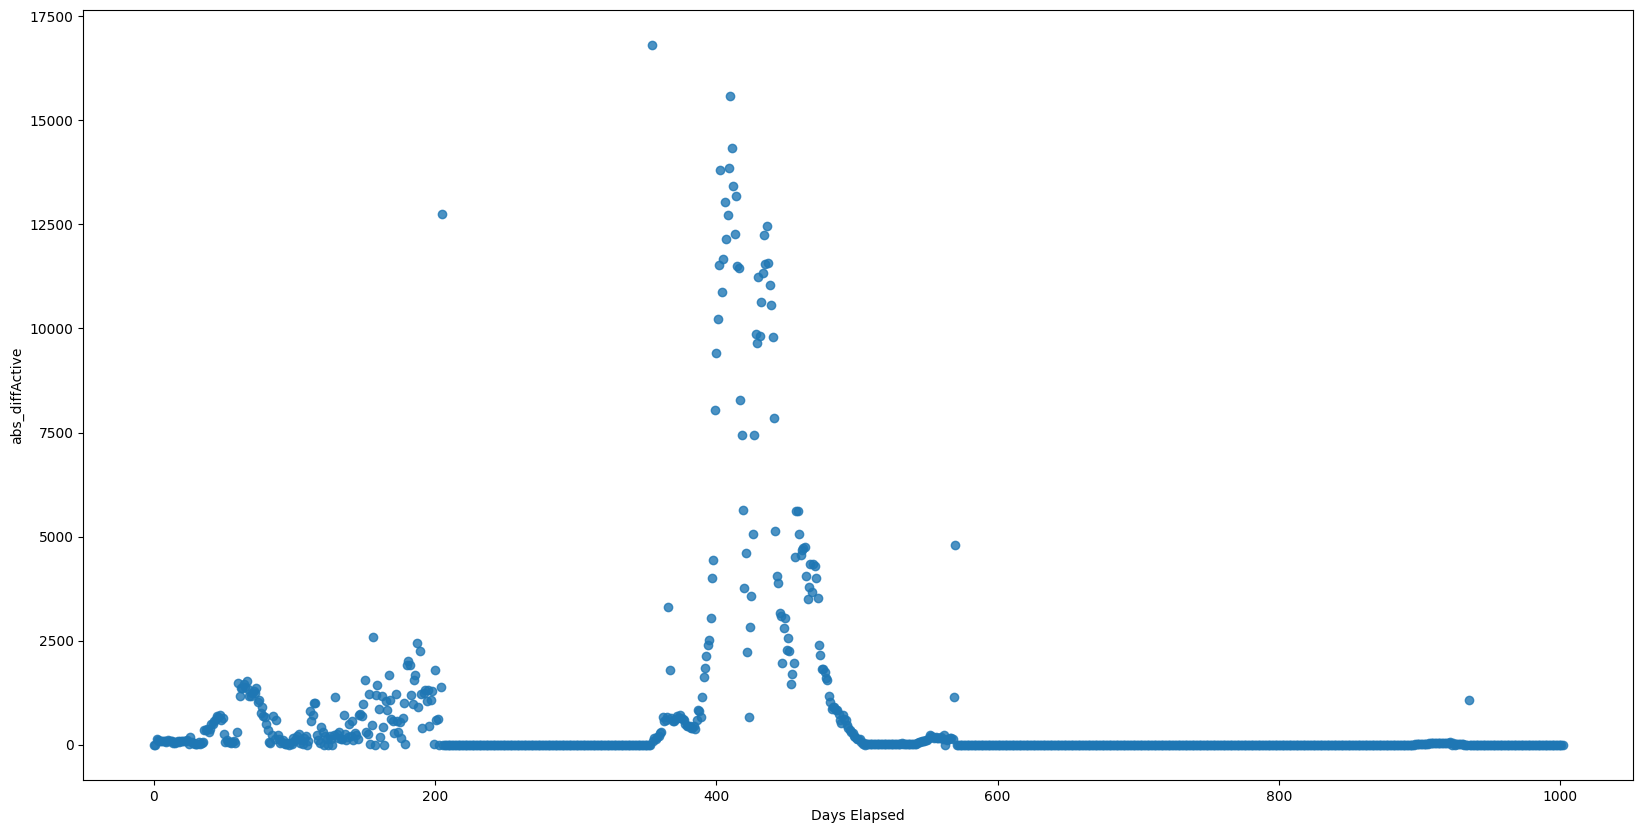

In [379]:
import seaborn as sns
sns.regplot(x='Days Elapsed', y='abs_diffActive', data=updated_df, fit_reg=False)
plt.show()

In [380]:
updated_df

,Confirmed,Deaths,Recovered,Active,Incident_Rate,Case_Fatality_Ratio,Year,abs_diffActive,abs_diffConfirmed,abs_diffDeaths,abs_diffRecovered,Days Elapsed
2020-12-31,817077,12109,796353.000000,8615.000000,1049.670736,1.481990,2020,0.000000,0.0,0.0,0.0,0
2021-01-01,817077,12109,796353.000000,8615.000000,1049.670736,1.481990,2020,0.000000,0.0,0.0,0.0,1
2021-01-02,816132,12092,795293.000000,8747.000000,1048.456727,1.481623,2020,132.000000,945.0,17.0,1060.0,2
2021-01-03,815175,12080,794228.000000,8867.000000,1047.227302,1.481890,2020,120.000000,957.0,12.0,1065.0,3
2021-01-04,814170,12069,793154.000000,8947.000000,1045.936213,1.482369,2020,80.000000,1005.0,11.0,1074.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-25,3594487,38049,923162.938242,4617.713892,1268.847776,1.432861,2023,0.008993,7.0,0.0,0.0,998
2023-09-26,3594478,38049,923162.938242,4617.702330,1268.847776,1.432861,2023,0.011562,9.0,0.0,0.0,999
2023-09-27,3594466,38049,923162.938242,4617.686914,1268.847776,1.432861,2023,0.015416,12.0,0.0,0.0,1000
2023-09-28,3594456,38049,923162.938242,4617.674067,1268.847776,1.432861,2023,0.012847,10.0,0.0,0.0,1001


In [381]:
# Linear Regression Model


# Split the Data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

X = updated_df['Days Elapsed']
X = X.values.reshape(-1,1)
y = updated_df['Active']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.75)

linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_test_pred = linreg.predict(X_test)
y_train_pred = linreg.predict(X_train)

In [382]:
#for trainning 
linreg.score(X_train, y_train)


0.04855735148766471

In [383]:
#for testing
linreg.score(X_test, y_test)


0.08159492723267037

In [384]:

print ('Co-efficient',linreg.coef_)
print ('Intercept',linreg.intercept_)

Co-efficient [-38.72051435]
Intercept 43665.17993129288


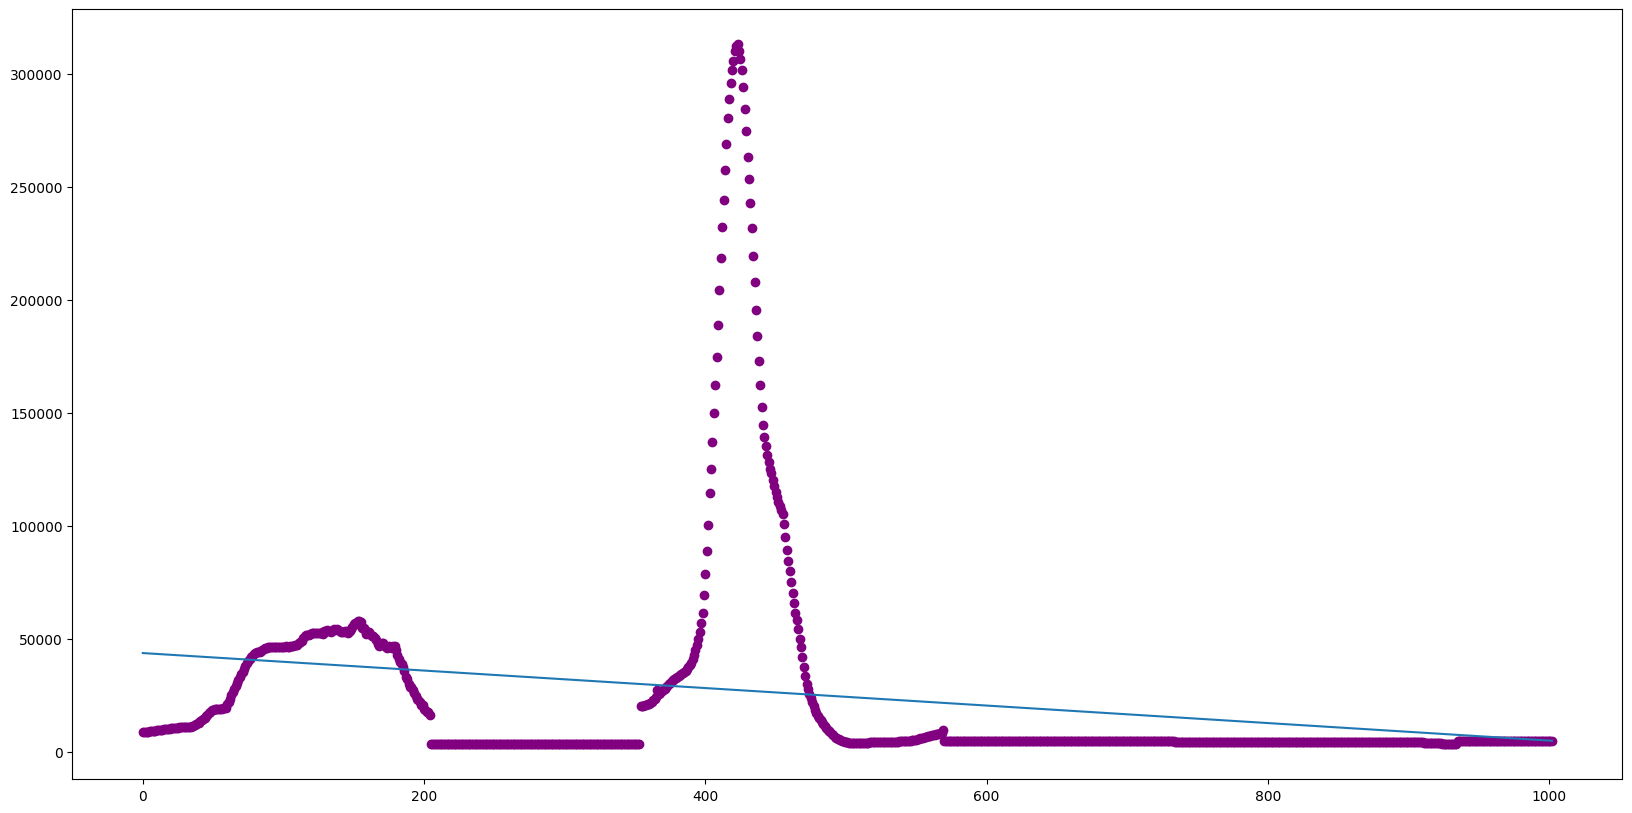

In [385]:
# Plot the Regression Line based on the Best fit line
reg_line=[(linreg.coef_*x)+linreg.intercept_ for x in updated_df['Days Elapsed']]
plt.scatter(updated_df['Days Elapsed'],updated_df['Active'],color="purple")
plt.plot(updated_df['Days Elapsed'],reg_line)
plt.show()


In [386]:

print("EVALUATION OF THE MODEL")
print("______________________________________________")
print("")
print('Root Mean Squared Error :', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print("______________________________________________")
print("")
print("r2 error:", r2_score(y_test, y_test_pred))
print("______________________________________________")
print("")
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_test_pred))
print("______________________________________________")
print("")
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_test_pred))
print("______________________________________________")
print("")

EVALUATION OF THE MODEL
______________________________________________

Root Mean Squared Error : 41040.82641080823
______________________________________________

r2 error: 0.08159492723267037
______________________________________________

Mean Absolute Error: 20683.381289514724
______________________________________________

Mean Squared Error: 1684349432.4820945
______________________________________________



In [387]:
accuracy =r2_score(y_test, y_test_pred)

In [388]:
print("Linear Regression Model Accuracy:", round(accuracy*100, 2), "%")

Linear Regression Model Accuracy: 8.16 %


In [389]:
#Multiple Linear Regression With scikit-learn
import pandas
import numpy as np
import seaborn as sns


In [390]:
df = pandas.read_csv("sorted_data.csv") 
df.head()

,FIPS,Province_State,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio,Year
0,12-31-2020,Tamil Nadu,01-01-2021 05:23,11.006091,78.400624,817077,12109,796353,8615.0,"Tamil Nadu, India",1049.670736,1.481990,2020
1,12-30-2020,Tamil Nadu,31-12-2020 05:22,11.006091,78.400624,817077,12109,796353,8615.0,"Tamil Nadu, India",1049.670736,1.481990,2020
2,12-29-2020,Tamil Nadu,30-12-2020 05:22,11.006091,78.400624,816132,12092,795293,8747.0,"Tamil Nadu, India",1048.456727,1.481623,2020
3,12-28-2020,Tamil Nadu,29-12-2020 05:22,11.006091,78.400624,815175,12080,794228,8867.0,"Tamil Nadu, India",1047.227302,1.481890,2020
4,12-27-2020,Tamil Nadu,28-12-2020 05:22,11.006091,78.400624,814170,12069,793154,8947.0,"Tamil Nadu, India",1045.936213,1.482369,2020


In [391]:
df.tail()

,FIPS,Province_State,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio,Year
998,01-05-2023,Tamil Nadu,06-01-2023 04:21,11.006091,78.400624,3594487,38049,"Tamil Nadu, India",4617.713892,1.0585377,NaN,NaN,2023
999,01-04-2023,Tamil Nadu,05-01-2023 04:21,11.006091,78.400624,3594478,38049,"Tamil Nadu, India",4617.702330,1.05854035,NaN,NaN,2023
1000,01-03-2023,Tamil Nadu,04-01-2023 04:21,11.006091,78.400624,3594466,38049,"Tamil Nadu, India",4617.686914,1.058543884,NaN,NaN,2023
1001,01-02-2023,Tamil Nadu,03-01-2023 04:21,11.006091,78.400624,3594456,38049,"Tamil Nadu, India",4617.674067,1.058546829,NaN,NaN,2023
1002,01-01-2023,Tamil Nadu,02-01-2023 04:20,11.006091,78.400624,3594444,38049,"Tamil Nadu, India",4617.658651,1.058550363,NaN,NaN,2023


In [392]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   FIPS                 1003 non-null   object 
 1   Province_State       1003 non-null   object 
 2   Last_Update          1003 non-null   object 
 3   Lat                  1003 non-null   float64
 4   Long_                1003 non-null   float64
 5   Confirmed            1003 non-null   int64  
 6   Deaths               1003 non-null   int64  
 7   Recovered            1003 non-null   object 
 8   Active               1003 non-null   float64
 9   Combined_Key         1003 non-null   object 
 10  Incident_Rate        421 non-null    float64
 11  Case_Fatality_Ratio  421 non-null    float64
 12  Year                 1003 non-null   int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 102.0+ KB


In [393]:
df['Recovered'] = df['Recovered'].apply(pandas.to_numeric, errors='coerce')

In [394]:
updated_df = df

In [395]:
updated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   FIPS                 1003 non-null   object 
 1   Province_State       1003 non-null   object 
 2   Last_Update          1003 non-null   object 
 3   Lat                  1003 non-null   float64
 4   Long_                1003 non-null   float64
 5   Confirmed            1003 non-null   int64  
 6   Deaths               1003 non-null   int64  
 7   Recovered            421 non-null    float64
 8   Active               1003 non-null   float64
 9   Combined_Key         1003 non-null   object 
 10  Incident_Rate        421 non-null    float64
 11  Case_Fatality_Ratio  421 non-null    float64
 12  Year                 1003 non-null   int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 102.0+ KB


In [396]:
# updated_df['Recovered']=updated_df['Recovered'].fillna(updated_df['Recovered'].mean())
# updated_df['Incident_Rate']=updated_df['Incident_Rate'].fillna(updated_df['Incident_Rate'].mean())
# updated_df['Case_Fatality_Ratio']=updated_df['Case_Fatality_Ratio'].fillna(updated_df['Case_Fatality_Ratio'].mean())
updated_df['Recovered']=updated_df['Recovered'].fillna(updated_df['Recovered'].median())
updated_df['Incident_Rate']=updated_df['Incident_Rate'].fillna(updated_df['Incident_Rate'].mean())
updated_df['Case_Fatality_Ratio']=updated_df['Case_Fatality_Ratio'].fillna(updated_df['Case_Fatality_Ratio'].mean())

In [397]:
updated_df.isnull().sum()

FIPS                   0
Province_State         0
Last_Update            0
Lat                    0
Long_                  0
Confirmed              0
Deaths                 0
Recovered              0
Active                 0
Combined_Key           0
Incident_Rate          0
Case_Fatality_Ratio    0
Year                   0
dtype: int64

In [398]:
updated_df.tail()

,FIPS,Province_State,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio,Year
998,01-05-2023,Tamil Nadu,06-01-2023 04:21,11.006091,78.400624,3594487,38049,803328.0,4617.713892,1.0585377,1268.847776,1.432861,2023
999,01-04-2023,Tamil Nadu,05-01-2023 04:21,11.006091,78.400624,3594478,38049,803328.0,4617.702330,1.05854035,1268.847776,1.432861,2023
1000,01-03-2023,Tamil Nadu,04-01-2023 04:21,11.006091,78.400624,3594466,38049,803328.0,4617.686914,1.058543884,1268.847776,1.432861,2023
1001,01-02-2023,Tamil Nadu,03-01-2023 04:21,11.006091,78.400624,3594456,38049,803328.0,4617.674067,1.058546829,1268.847776,1.432861,2023
1002,01-01-2023,Tamil Nadu,02-01-2023 04:20,11.006091,78.400624,3594444,38049,803328.0,4617.658651,1.058550363,1268.847776,1.432861,2023


In [399]:
updated_df.head()

,FIPS,Province_State,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio,Year
0,12-31-2020,Tamil Nadu,01-01-2021 05:23,11.006091,78.400624,817077,12109,796353.0,8615.0,"Tamil Nadu, India",1049.670736,1.481990,2020
1,12-30-2020,Tamil Nadu,31-12-2020 05:22,11.006091,78.400624,817077,12109,796353.0,8615.0,"Tamil Nadu, India",1049.670736,1.481990,2020
2,12-29-2020,Tamil Nadu,30-12-2020 05:22,11.006091,78.400624,816132,12092,795293.0,8747.0,"Tamil Nadu, India",1048.456727,1.481623,2020
3,12-28-2020,Tamil Nadu,29-12-2020 05:22,11.006091,78.400624,815175,12080,794228.0,8867.0,"Tamil Nadu, India",1047.227302,1.481890,2020
4,12-27-2020,Tamil Nadu,28-12-2020 05:22,11.006091,78.400624,814170,12069,793154.0,8947.0,"Tamil Nadu, India",1045.936213,1.482369,2020


In [400]:
updated_df.tail()

,FIPS,Province_State,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio,Year
998,01-05-2023,Tamil Nadu,06-01-2023 04:21,11.006091,78.400624,3594487,38049,803328.0,4617.713892,1.0585377,1268.847776,1.432861,2023
999,01-04-2023,Tamil Nadu,05-01-2023 04:21,11.006091,78.400624,3594478,38049,803328.0,4617.702330,1.05854035,1268.847776,1.432861,2023
1000,01-03-2023,Tamil Nadu,04-01-2023 04:21,11.006091,78.400624,3594466,38049,803328.0,4617.686914,1.058543884,1268.847776,1.432861,2023
1001,01-02-2023,Tamil Nadu,03-01-2023 04:21,11.006091,78.400624,3594456,38049,803328.0,4617.674067,1.058546829,1268.847776,1.432861,2023
1002,01-01-2023,Tamil Nadu,02-01-2023 04:20,11.006091,78.400624,3594444,38049,803328.0,4617.658651,1.058550363,1268.847776,1.432861,2023


In [401]:
updated_df['abs_diffActive'] = updated_df['Active'].diff().abs()
updated_df['abs_diffConfirmed'] = updated_df['Confirmed'].diff().abs()
updated_df['abs_diffDeaths'] = updated_df['Deaths'].diff().abs()
updated_df['abs_diffRecovered'] = updated_df['Recovered'].diff().abs()

In [402]:
updated_df.head()


,FIPS,Province_State,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio,Year,abs_diffActive,abs_diffConfirmed,abs_diffDeaths,abs_diffRecovered
0,12-31-2020,Tamil Nadu,01-01-2021 05:23,11.006091,78.400624,817077,12109,796353.0,8615.0,"Tamil Nadu, India",1049.670736,1.481990,2020,NaN,NaN,NaN,NaN
1,12-30-2020,Tamil Nadu,31-12-2020 05:22,11.006091,78.400624,817077,12109,796353.0,8615.0,"Tamil Nadu, India",1049.670736,1.481990,2020,0.0,0.0,0.0,0.0
2,12-29-2020,Tamil Nadu,30-12-2020 05:22,11.006091,78.400624,816132,12092,795293.0,8747.0,"Tamil Nadu, India",1048.456727,1.481623,2020,132.0,945.0,17.0,1060.0
3,12-28-2020,Tamil Nadu,29-12-2020 05:22,11.006091,78.400624,815175,12080,794228.0,8867.0,"Tamil Nadu, India",1047.227302,1.481890,2020,120.0,957.0,12.0,1065.0
4,12-27-2020,Tamil Nadu,28-12-2020 05:22,11.006091,78.400624,814170,12069,793154.0,8947.0,"Tamil Nadu, India",1045.936213,1.482369,2020,80.0,1005.0,11.0,1074.0


In [403]:
updated_df.fillna(0)

,FIPS,Province_State,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio,Year,abs_diffActive,abs_diffConfirmed,abs_diffDeaths,abs_diffRecovered
0,12-31-2020,Tamil Nadu,01-01-2021 05:23,11.006091,78.400624,817077,12109,796353.0,8615.000000,"Tamil Nadu, India",1049.670736,1.481990,2020,0.000000,0.0,0.0,0.0
1,12-30-2020,Tamil Nadu,31-12-2020 05:22,11.006091,78.400624,817077,12109,796353.0,8615.000000,"Tamil Nadu, India",1049.670736,1.481990,2020,0.000000,0.0,0.0,0.0
2,12-29-2020,Tamil Nadu,30-12-2020 05:22,11.006091,78.400624,816132,12092,795293.0,8747.000000,"Tamil Nadu, India",1048.456727,1.481623,2020,132.000000,945.0,17.0,1060.0
3,12-28-2020,Tamil Nadu,29-12-2020 05:22,11.006091,78.400624,815175,12080,794228.0,8867.000000,"Tamil Nadu, India",1047.227302,1.481890,2020,120.000000,957.0,12.0,1065.0
4,12-27-2020,Tamil Nadu,28-12-2020 05:22,11.006091,78.400624,814170,12069,793154.0,8947.000000,"Tamil Nadu, India",1045.936213,1.482369,2020,80.000000,1005.0,11.0,1074.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,01-05-2023,Tamil Nadu,06-01-2023 04:21,11.006091,78.400624,3594487,38049,803328.0,4617.713892,1.0585377,1268.847776,1.432861,2023,0.008993,7.0,0.0,0.0
999,01-04-2023,Tamil Nadu,05-01-2023 04:21,11.006091,78.400624,3594478,38049,803328.0,4617.702330,1.05854035,1268.847776,1.432861,2023,0.011562,9.0,0.0,0.0
1000,01-03-2023,Tamil Nadu,04-01-2023 04:21,11.006091,78.400624,3594466,38049,803328.0,4617.686914,1.058543884,1268.847776,1.432861,2023,0.015416,12.0,0.0,0.0
1001,01-02-2023,Tamil Nadu,03-01-2023 04:21,11.006091,78.400624,3594456,38049,803328.0,4617.674067,1.058546829,1268.847776,1.432861,2023,0.012847,10.0,0.0,0.0


In [404]:
updated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   FIPS                 1003 non-null   object 
 1   Province_State       1003 non-null   object 
 2   Last_Update          1003 non-null   object 
 3   Lat                  1003 non-null   float64
 4   Long_                1003 non-null   float64
 5   Confirmed            1003 non-null   int64  
 6   Deaths               1003 non-null   int64  
 7   Recovered            1003 non-null   float64
 8   Active               1003 non-null   float64
 9   Combined_Key         1003 non-null   object 
 10  Incident_Rate        1003 non-null   float64
 11  Case_Fatality_Ratio  1003 non-null   float64
 12  Year                 1003 non-null   int64  
 13  abs_diffActive       1002 non-null   float64
 14  abs_diffConfirmed    1002 non-null   float64
 15  abs_diffDeaths       1002 non-null   f

In [405]:
updated_df = updated_df.fillna(0).reset_index(drop=True)

In [406]:
updated_df.head()

,FIPS,Province_State,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio,Year,abs_diffActive,abs_diffConfirmed,abs_diffDeaths,abs_diffRecovered
0,12-31-2020,Tamil Nadu,01-01-2021 05:23,11.006091,78.400624,817077,12109,796353.0,8615.0,"Tamil Nadu, India",1049.670736,1.481990,2020,0.0,0.0,0.0,0.0
1,12-30-2020,Tamil Nadu,31-12-2020 05:22,11.006091,78.400624,817077,12109,796353.0,8615.0,"Tamil Nadu, India",1049.670736,1.481990,2020,0.0,0.0,0.0,0.0
2,12-29-2020,Tamil Nadu,30-12-2020 05:22,11.006091,78.400624,816132,12092,795293.0,8747.0,"Tamil Nadu, India",1048.456727,1.481623,2020,132.0,945.0,17.0,1060.0
3,12-28-2020,Tamil Nadu,29-12-2020 05:22,11.006091,78.400624,815175,12080,794228.0,8867.0,"Tamil Nadu, India",1047.227302,1.481890,2020,120.0,957.0,12.0,1065.0
4,12-27-2020,Tamil Nadu,28-12-2020 05:22,11.006091,78.400624,814170,12069,793154.0,8947.0,"Tamil Nadu, India",1045.936213,1.482369,2020,80.0,1005.0,11.0,1074.0


In [407]:
updated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   FIPS                 1003 non-null   object 
 1   Province_State       1003 non-null   object 
 2   Last_Update          1003 non-null   object 
 3   Lat                  1003 non-null   float64
 4   Long_                1003 non-null   float64
 5   Confirmed            1003 non-null   int64  
 6   Deaths               1003 non-null   int64  
 7   Recovered            1003 non-null   float64
 8   Active               1003 non-null   float64
 9   Combined_Key         1003 non-null   object 
 10  Incident_Rate        1003 non-null   float64
 11  Case_Fatality_Ratio  1003 non-null   float64
 12  Year                 1003 non-null   int64  
 13  abs_diffActive       1003 non-null   float64
 14  abs_diffConfirmed    1003 non-null   float64
 15  abs_diffDeaths       1003 non-null   f

In [408]:
updated_df = updated_df.drop(['Lat','Long_','Combined_Key','Year'],axis=1)

In [409]:
updated_df.corr(numeric_only = True)

,Confirmed,Deaths,Recovered,Active,Incident_Rate,Case_Fatality_Ratio,abs_diffActive,abs_diffConfirmed,abs_diffDeaths,abs_diffRecovered
Confirmed,1.000000,0.980859,0.251070,-0.298457,0.372865,-0.185941,-0.172108,0.025014,0.011506,-0.019895
Deaths,0.980859,1.000000,0.319283,-0.317443,0.437189,-0.180477,-0.172774,0.027302,0.017110,-0.006857
Recovered,0.251070,0.319283,1.000000,0.324424,0.987721,-0.463344,0.429741,0.006434,0.014429,0.140570
Active,-0.298457,-0.317443,0.324424,1.000000,0.336667,-0.450003,0.758125,0.021737,0.036849,0.087517
Incident_Rate,0.372865,0.437189,0.987721,0.336667,1.000000,-0.498681,0.432972,0.013144,0.020110,0.133807
Case_Fatality_Ratio,-0.185941,-0.180477,-0.463344,-0.450003,-0.498681,1.000000,-0.509147,-0.022416,-0.023952,-0.069343
abs_diffActive,-0.172108,-0.172774,0.429741,0.758125,0.432972,-0.509147,1.000000,0.185910,0.210708,0.348843
abs_diffConfirmed,0.025014,0.027302,0.006434,0.021737,0.013144,-0.022416,0.185910,1.000000,0.966323,0.285966
abs_diffDeaths,0.011506,0.017110,0.014429,0.036849,0.020110,-0.023952,0.210708,0.966323,1.000000,0.342415
abs_diffRecovered,-0.019895,-0.006857,0.140570,0.087517,0.133807,-0.069343,0.348843,0.285966,0.342415,1.000000


<AxesSubplot:>

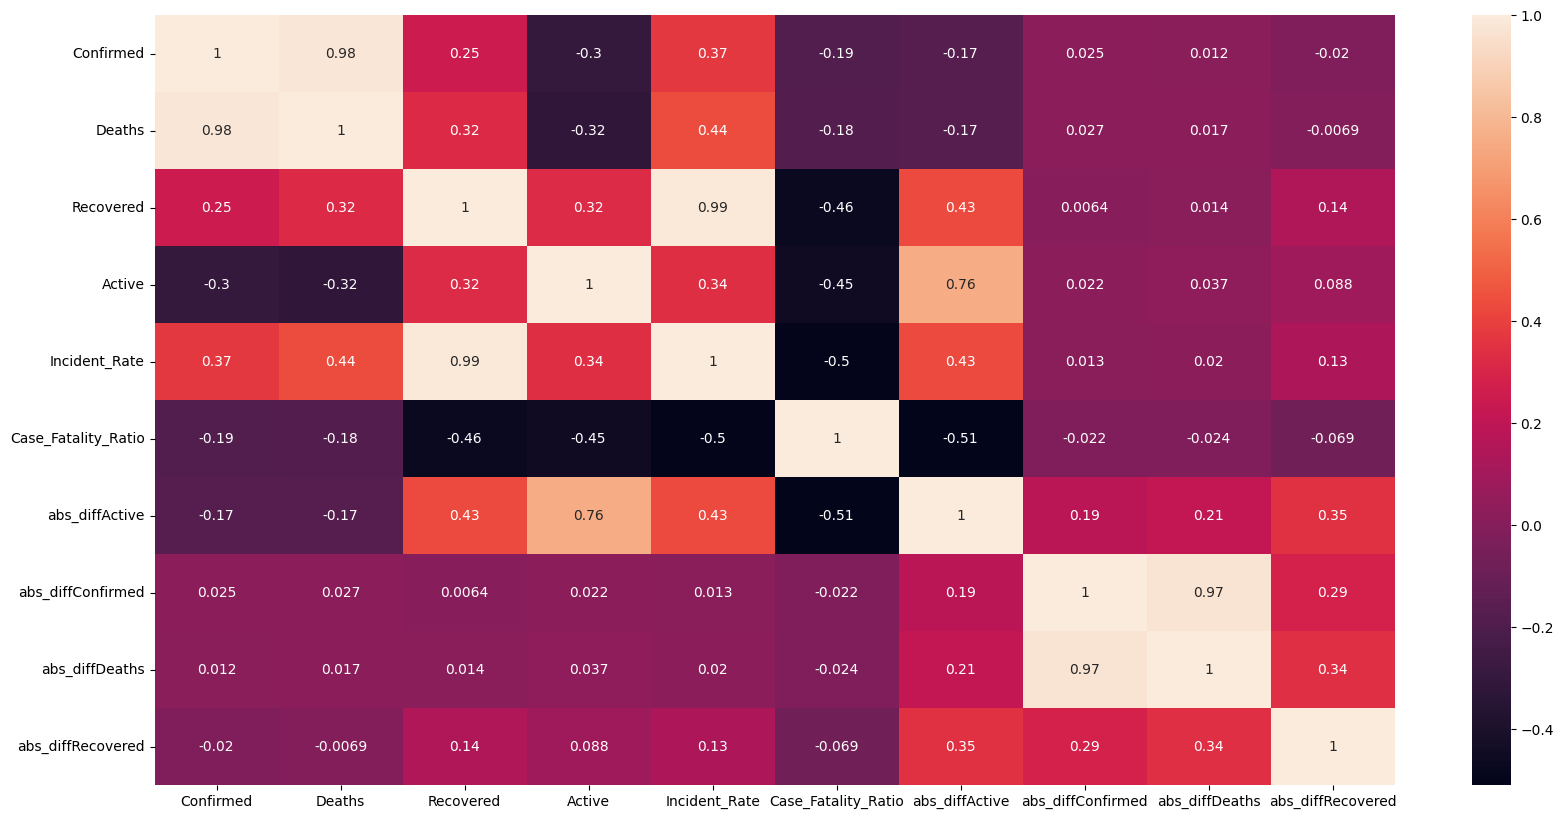

In [410]:
sns.heatmap(updated_df.corr(numeric_only = True),annot=True)

In [411]:
updated_df.max()

FIPS                         12-31-2022
Province_State               Tamil Nadu
Last_Update            31-12-2022 04:20
Confirmed                       3595123
Deaths                            38049
Recovered                     2513087.0
Active                         313048.0
Incident_Rate               3298.251813
Case_Fatality_Ratio            1.726175
abs_diffActive              16816.18271
abs_diffConfirmed             2775495.0
abs_diffDeaths                  36469.0
abs_diffRecovered             1709759.0
dtype: object

In [412]:
updated_df.min()

FIPS                         01-01-2021
Province_State               Tamil Nadu
Last_Update            01-01-2021 05:23
Confirmed                         34914
Deaths                              307
Recovered                       18325.0
Active                       3300.81729
Incident_Rate                 44.852816
Case_Fatality_Ratio            0.879303
abs_diffActive                      0.0
abs_diffConfirmed                   0.0
abs_diffDeaths                      0.0
abs_diffRecovered                   0.0
dtype: object

In [413]:
# abs_diffActive 	abs_diffConfirmed 	abs_diffDeaths 	abs_diffRecovered
#X = updated_df[['abs_diffConfirmed', 'abs_diffDeaths', 'abs_diffRecovered','Incident_Rate','Case_Fatality_Ratio']]
#y = updated_df['abs_diffActive'] 
X = df[['Confirmed', 'Deaths', 'Recovered']]# 'Incident_Rate','Case_Fatality_Ratio'
y = df['Active'] 

In [414]:
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

x_train, x_test,y_train,y_test = train_test_split(X,y,train_size=0.75)
# print the data
x_train

,Confirmed,Deaths,Recovered
599,3594173,38049,803328.0
882,3446388,37989,803328.0
199,46504,479,25344.0
711,3557254,38033,803328.0
672,3577808,38040,803328.0
...,...,...,...
830,3453210,38025,803328.0
406,2353721,29547,2174247.0
7,811115,12036,789862.0
634,3591571,38048,803328.0


In [415]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(x_train,y_train)

In [416]:
model.predict(x_test)

array([ 32876.59436627,  39316.53364167,   7959.51280791,  97734.33106105,
        86820.70404996,   8101.35087562,  45383.7411474 ,  33256.75552855,
       -16757.87791527,  14233.24225608, -17248.28360932,   7529.05023535,
       -19162.98650299,  14214.70490526,  11429.0992034 ,  96399.17144036,
        14218.63104658,   7695.7158691 ,  41111.01363176,  30614.64706872,
        34722.30675714,  46334.40754091,  46631.51976011, -12190.69907875,
       -15977.33622875,  43652.38909458,  13352.38913032,  14191.19775528,
        96740.54889405,  14232.64588018,  14212.51819363,   7210.57047386,
        29847.12083986,   9972.48709372, -19531.22945903, -18733.36368923,
        96744.66069716,   6426.19218127,   7458.97606735,   7354.65998322,
        52714.38320171,  46618.63697468,  14251.77960691,  47174.46316123,
         7463.39918859,   7231.97710407, -15301.80230151,  12433.32508769,
        14220.8674562 ,  45700.8178034 ,  46799.23207837,   7550.71855964,
         7364.6989775 ,  

In [417]:
model.score(x_train,y_train)

0.360414011374121

In [418]:
 print(f"intercept: {model.intercept_}")

intercept: 32798.330713879186


In [419]:
print(f"coefficients: {model.coef_}")

coefficients: [ 0.04969799 -6.53186659  0.06387683]


In [420]:
y_pred = model.predict(x_test)

In [421]:
from sklearn.metrics import r2_score
Accuracy=r2_score(y_test,y_pred)*100
print(" Accuracy of the model is %.2f" %Accuracy)

 Accuracy of the model is 33.87


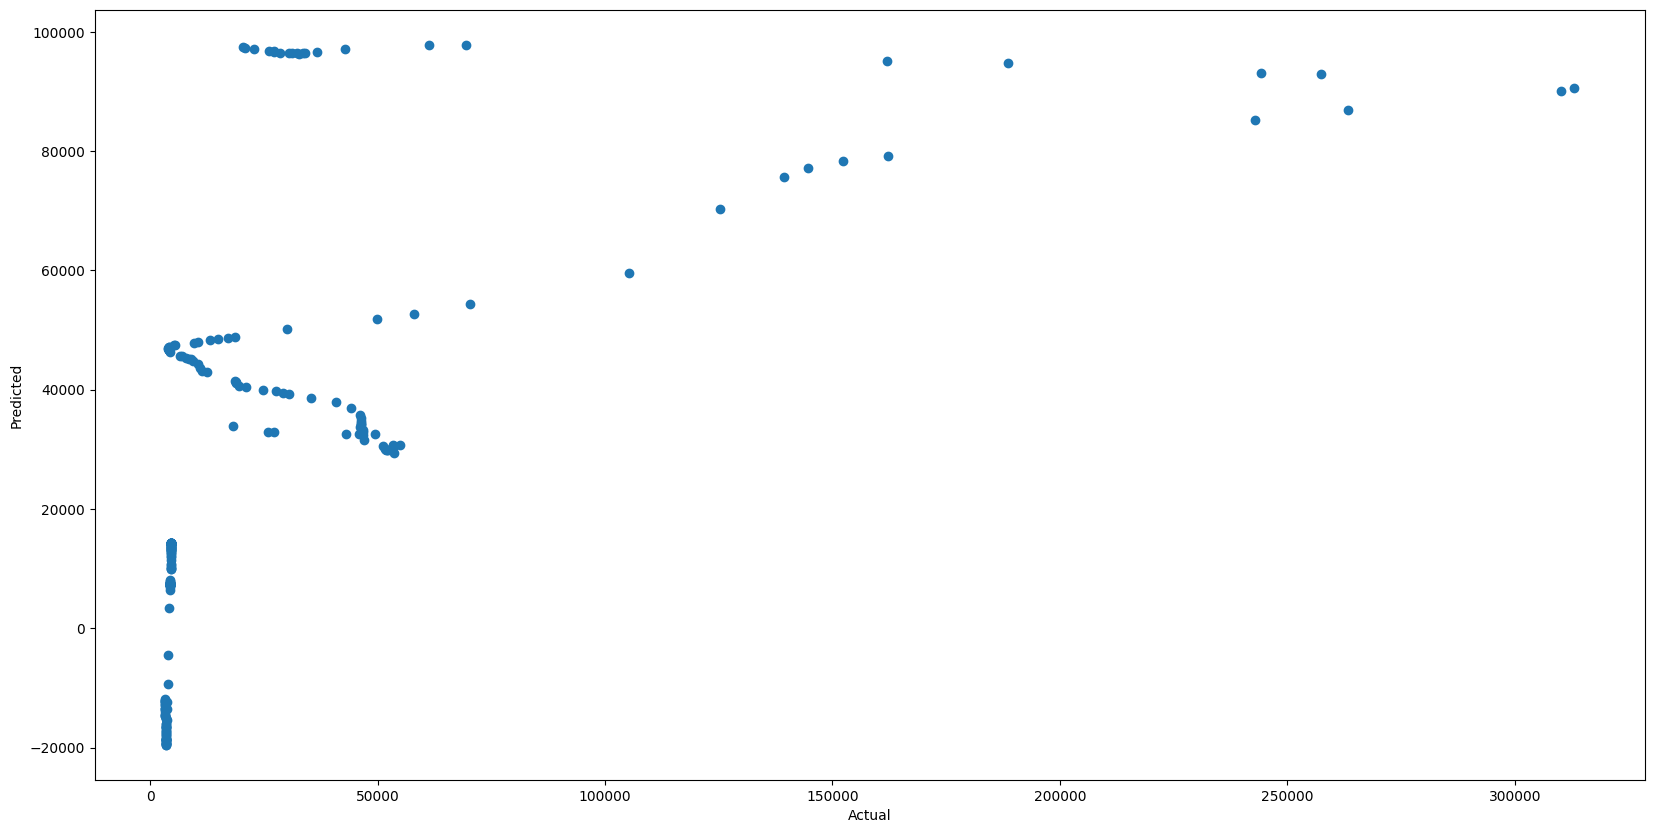

In [422]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

<AxesSubplot:xlabel='Active'>

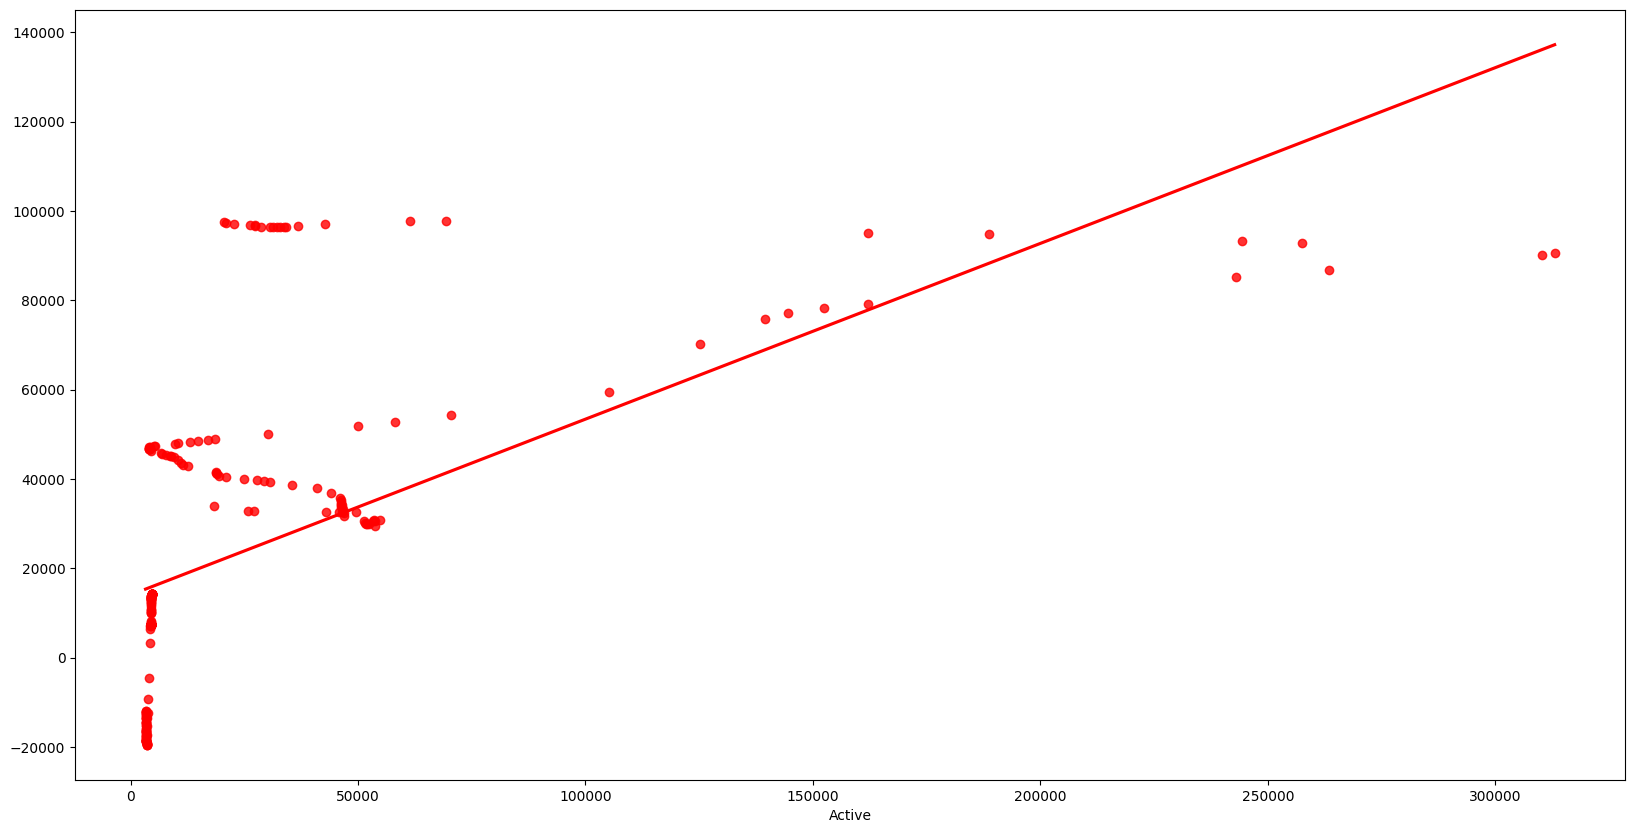

In [423]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red')

In [424]:
pred_df=pandas.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
192,27181.000000,32876.594366,-5695.594366
67,30606.000000,39316.533642,-8710.533642
760,4451.995880,7959.512808,-3507.516928
399,69372.000000,97734.331061,-28362.331061
430,263390.000000,86820.704050,176569.295950
...,...,...,...
316,3381.536685,-14640.010105,18021.546790
166,49455.000000,32610.668957,16844.331043
357,20524.000000,97491.074292,-76967.074292
699,4579.858650,12860.230835,-8280.372185


In [425]:
# max values
# FIPS                         12-31-2022
# Province_State               Tamil Nadu
# Last_Update            31-12-2022 04:20
# Confirmed                       3595123
# Deaths                            38049
# Recovered                     2513087.0
# Active                         313048.0
# Incident_Rate               3298.251813
# Case_Fatality_Ratio            1.726175
# abs_diffActive              16816.18271
# abs_diffConfirmed             2775495.0
# abs_diffDeaths                  36469.0
# abs_diffRecovered        1589924.061758
# dtype: obje

In [426]:
# min values
# FIPS                         01-01-2021
# Province_State               Tamil Nadu
# Last_Update            01-01-2021 05:23
# Confirmed                         34914
# Deaths                              307
# Recovered                       18325.0
# Active                       3300.81729
# Incident_Rate                 44.852816
# Case_Fatality_Ratio            0.879303
# abs_diffActive                      0.0
# abs_diffConfirmed                   0.0
# abs_diffDeaths                      0.0
# abs_diffRecovered                   0.0
# dtype: object

In [427]:
x_new = pandas.DataFrame({'Confirmed': np.random.randint(34914, 3595123, 50),
               'Deaths': np.random.randint(307, 38049, 50),
               'Recovered': np.random.uniform(18325.0, 2513087.0, 50)})
#                'Incident_Rate': np.random.uniform(44.852816, 3298.251813, 50),
#                'Case_Fatality_Ratio': np.random.uniform(0.879303, 1.726175, 50)})

# x_new = pandas.DataFrame({'abs_diffConfirmed': np.random.randint(0.0, 2775495.0, 50),
#                'abs_diffDeaths': np.random.randint(0.0, 36469.0, 50),
#                'abs_diffRecovered': np.random.uniform(0.0, 1589924.061758, 50),
#                'Incident_Rate': np.random.uniform(44.852816, 3298.251813, 50),
#                'Case_Fatality_Ratio': np.random.uniform(0.879303, 1.726175, 50)})

#x_new = np.arange(5).reshape((-1, 5))

In [428]:
x_new

,Confirmed,Deaths,Recovered
0,846985,37009,1.366328e+06
1,281890,31773,1.448446e+06
2,3249184,31938,2.497011e+06
3,2293212,18151,1.038112e+06
4,2640990,19310,1.594892e+05
5,2331306,34563,2.667815e+05
6,807683,10688,1.564824e+05
7,1910149,32451,8.049557e+05
8,2096050,8048,1.531942e+05
9,1588616,34477,2.146866e+06


In [429]:
y_new = model.predict(x_new) 

In [430]:
y_new

array([-79569.35510889, -68207.13905649, 145162.64031654,  94517.77210331,
        48107.55065739, -60060.19084118,  13121.56104267, -32818.68393754,
        94184.90083264,  23685.17554339, 163751.78979702, -59247.13209038,
       295342.27649291, 278369.73909595, 195026.27053594, 170561.51794531,
       136630.40881142,  25542.3752937 ,  62332.0941147 , 136941.24971728,
       160732.50290026, 149316.7634093 ,  10421.11555468, 189048.27044437,
        14494.00206883, 321297.15817355,  38251.09831783,   2074.29836812,
        33048.56042774,  68476.2422018 , 102343.58837483, 148940.4102166 ,
        44302.8829572 ,  60028.09818391, 145396.07021652, -26068.13403089,
        20189.46515994,  39519.05561207, 117292.70284922,  42177.65361362,
       -27062.10829778, 104805.36137599, 119956.21825024, 116790.29206654,
       220599.1837639 ,  12369.83707096,  80271.74273818, 224832.24911731,
       193303.91520863,  96209.15909912])

In [431]:
model.score(x_new,y_new)

1.0

Date
2020-06    38892.0
2020-07    57968.0
2020-08    52578.0
2020-09    46263.0
2020-10    22164.0
Freq: M, Name: Active, dtype: float64


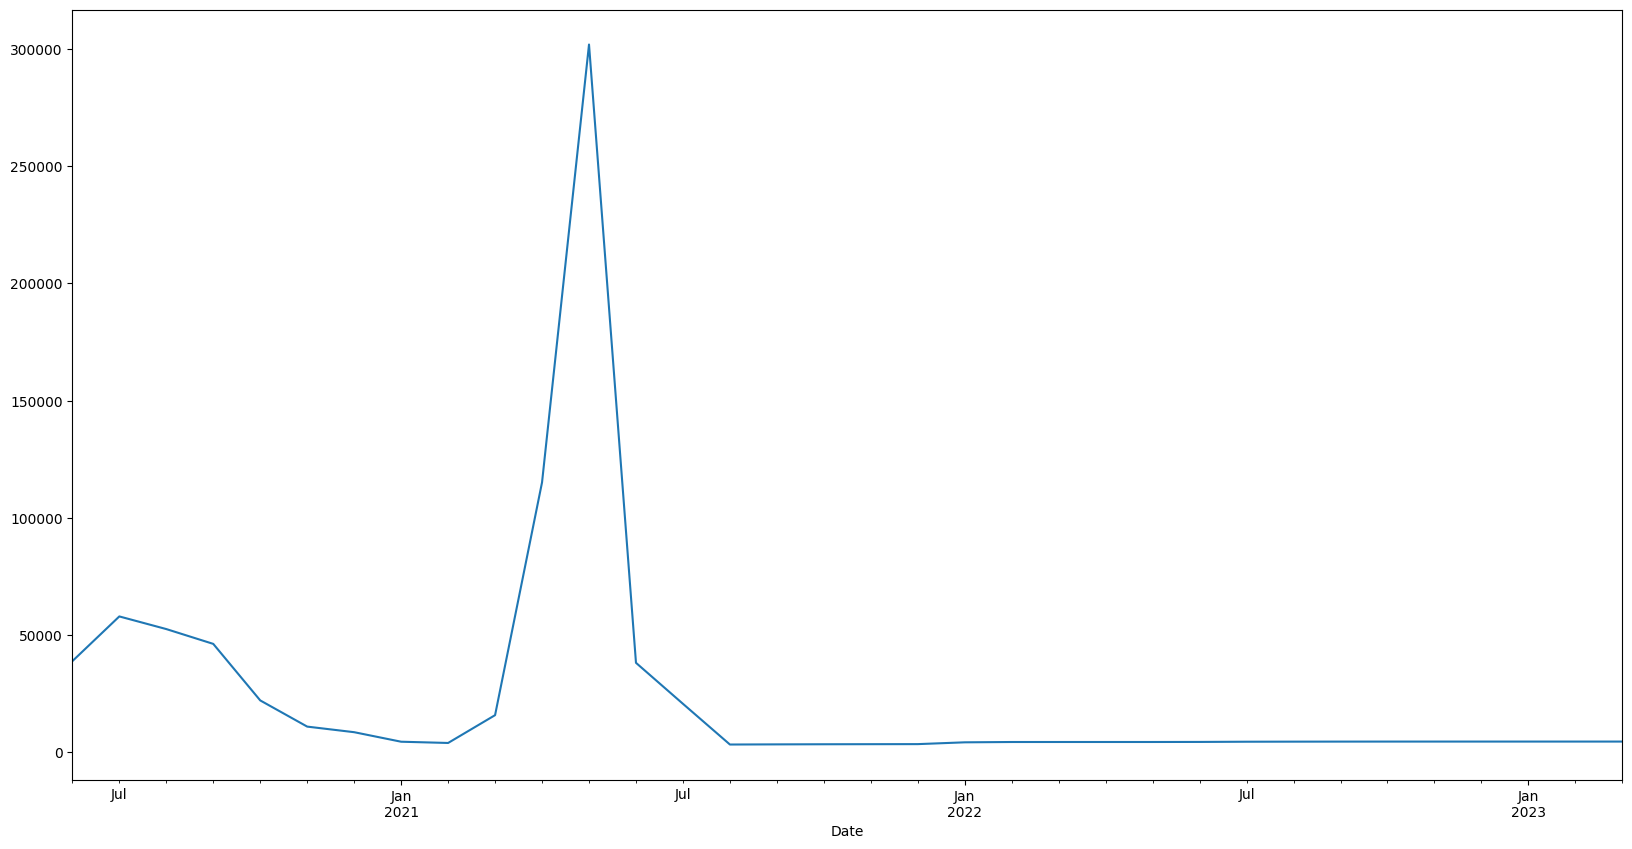

In [432]:
import pandas as pd
from pandas import read_csv
from datetime import datetime
from matplotlib import pyplot
def parser(x):
 return datetime.strptime(x,'%m-%d-%Y')

series = read_csv('sorted_data_arima.csv', header=0, parse_dates=[0], index_col=0, date_parser=parser).squeeze(1)

series = series.resample('M').interpolate()
series.index = series.index.to_period('m')


print(series.head())
series.plot()
pyplot.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

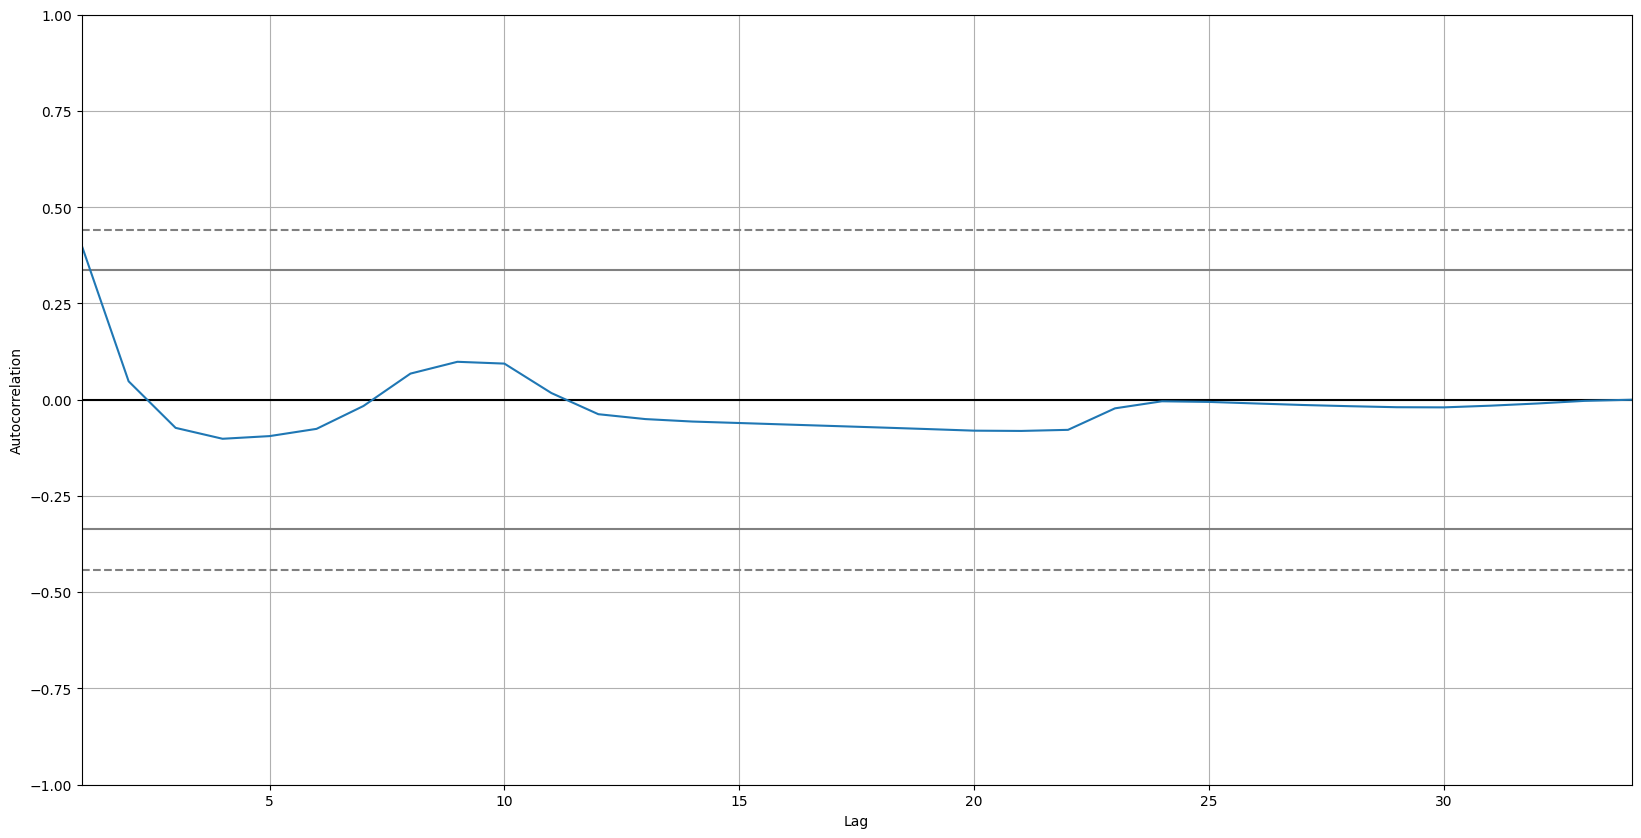

In [433]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)

In [434]:
from statsmodels.tsa.arima.model import ARIMA
# fit model
model = ARIMA(series, order=(2,1,0))
model_fit = model.fit()

In [435]:
# summary of fit model
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                 Active   No. Observations:                   34
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -407.845
Date:                Sun, 21 May 2023   AIC                            821.690
Time:                        23:45:08   BIC                            826.180
Sample:                    06-30-2020   HQIC                           823.201
                         - 03-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2500      0.092     -2.717      0.007      -0.430      -0.070
ar.L2         -0.2391      0.130     -1.832      0.067      -0.495       0.017
sigma2      3.349e+09   9.67e-12   3.46e+20      0.0

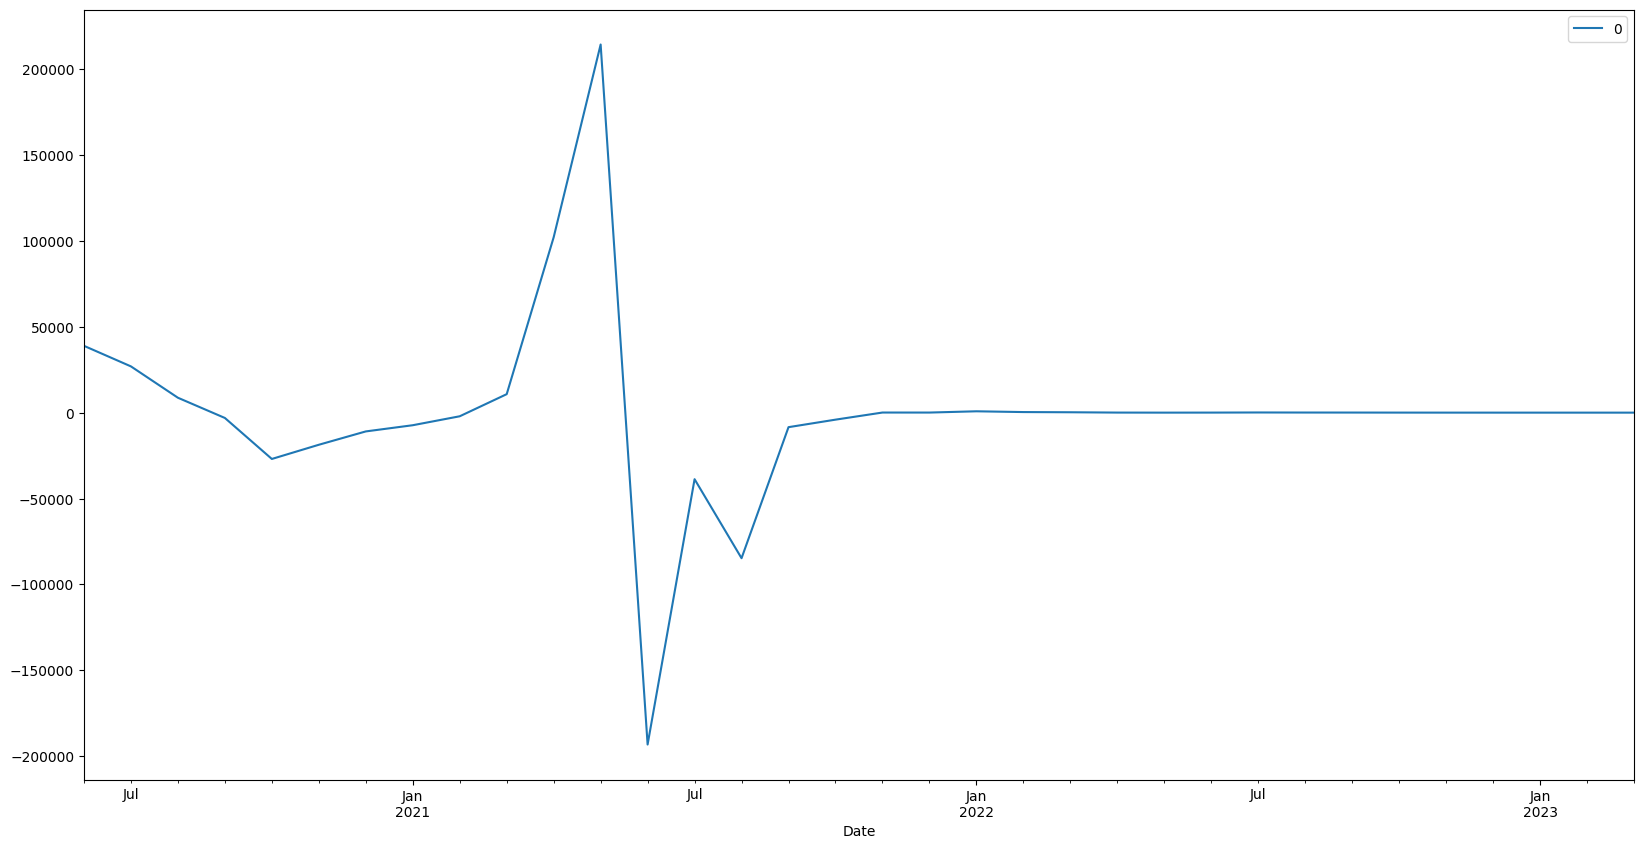

In [436]:
# line plot of residuals
from pandas import DataFrame
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()

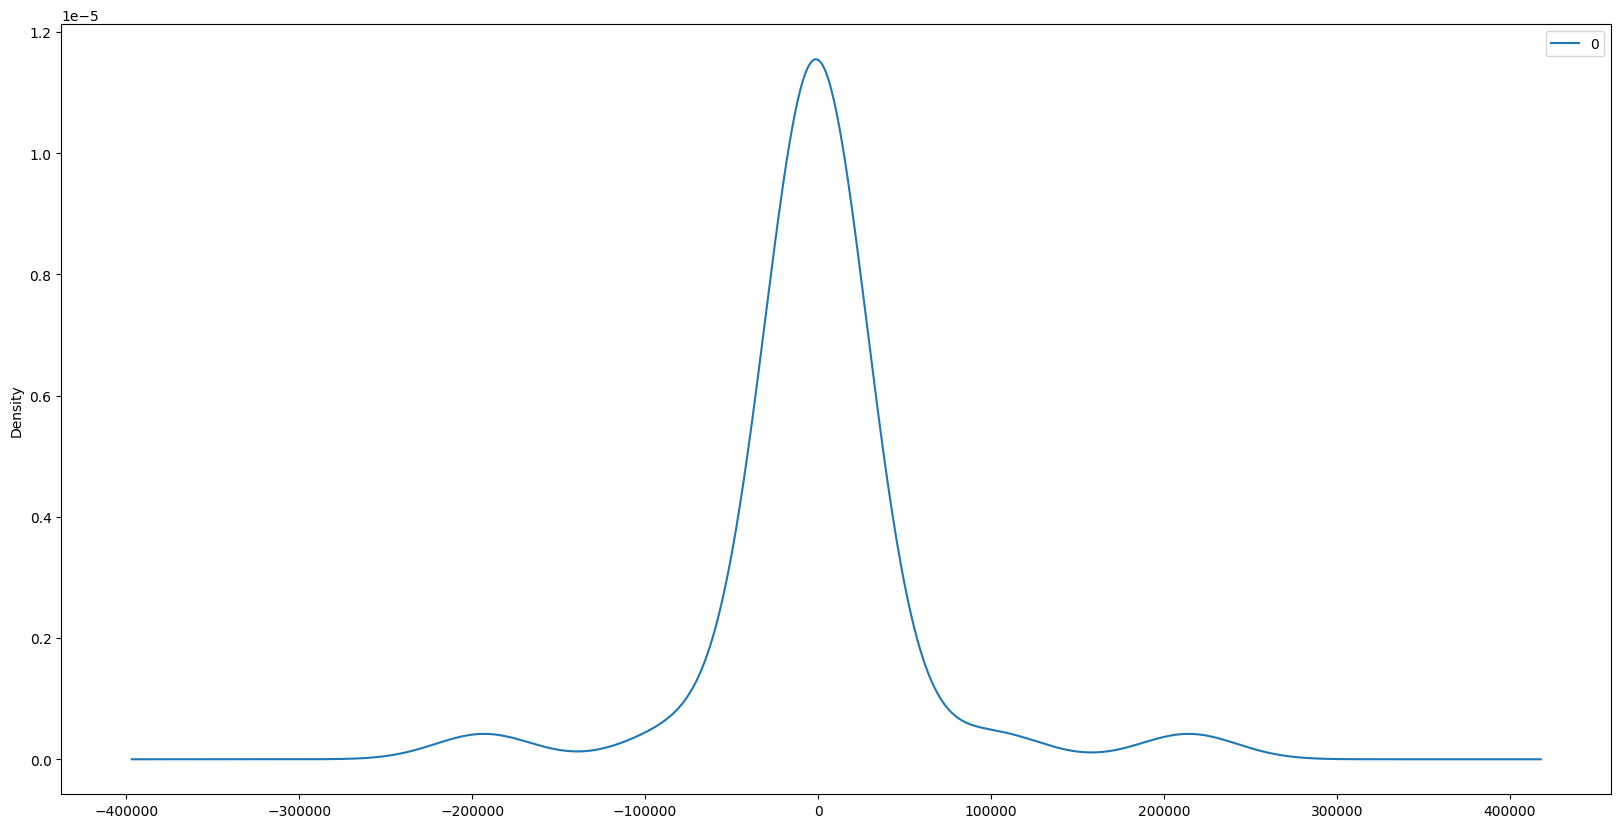

                   0
count      34.000000
mean      146.937614
std     56711.756508
min   -193203.541378
25%     -3838.403398
50%        16.813590
75%       189.849484
max    214297.529047


In [437]:
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

In [438]:
# split into train and test sets
X = series.values
size = int(len(X) * 0.65)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

In [439]:
# walk-forward validation
for t in range(len(test)):
 model = ARIMA(history, order=(1,1,0))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))

predicted=4434.840761, expected=4437.147715
predicted=4436.863965, expected=4439.128669
predicted=4438.733418, expected=4464.450714
predicted=4459.398311, expected=4553.171006
predicted=4535.469004, expected=4584.530979
predicted=4578.273848, expected=4603.090543
predicted=4599.387425, expected=4614.574169
predicted=4612.282884, expected=4617.273252
predicted=4616.734714, expected=4617.640666
predicted=4617.567357, expected=4617.934855
predicted=4617.876156, expected=4618.227758
predicted=4618.169316, expected=4618.227758


In [ ]:
# evaluate forecasts
from math import sqrt
from sklearn.metrics import mean_squared_error

rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

In [441]:
import numpy as np
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [442]:
print(mean_absolute_percentage_error(test, predictions))

0.40179108686268755


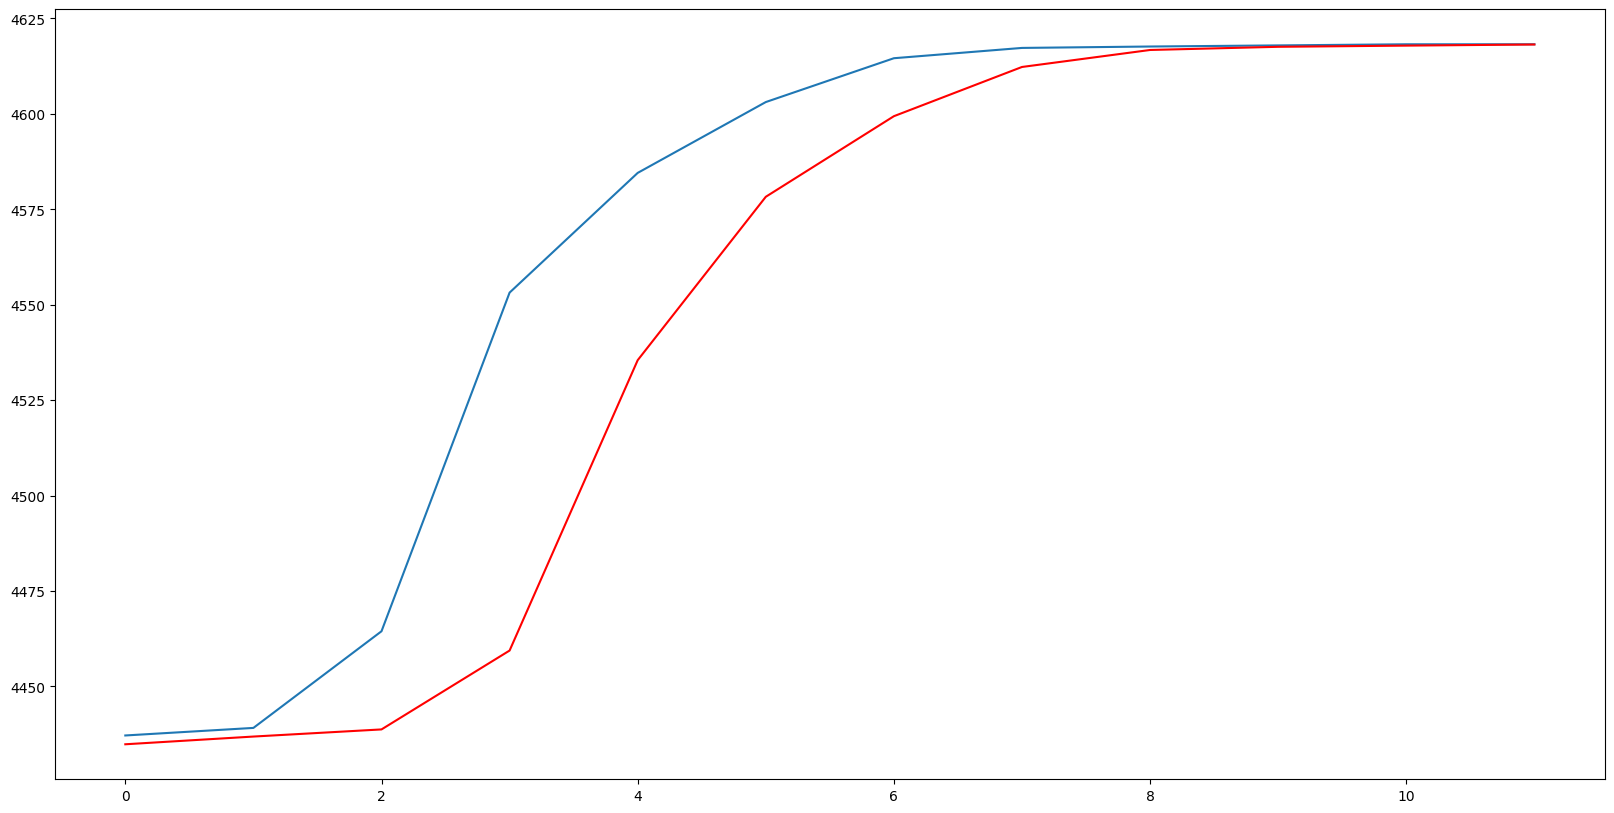

In [443]:
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()